<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.3: Optimization in Higher Dimensions: The need for speed**

### Objective: See how methods like propose and reject and perturb-measure-step become intractably slow for higher dimensional problems, i.e. they do not scale well. See that high-dimensional problems are ubiquitous in neural systems.

In this sequence we will:

* Explore how using propose-reject and pertrub-measure-step scale to much higher dimensions using simple high dimensional functions, using both simulations and mathematical analysis.

* Introduce a slightly more complex version of the strike-no-strike problem where the decision depends on 64 features instead of 1, and develop an Neural Network archetecture that can solve this problem

* Use perturb-measure-step and propose-reject to train this network

* Solve this same problem but with a deeper network and see that although learning takes longer, final perforance is better.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S2"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.3.1: Optimizing a Quadratic of Many Variables Analytically

Last sequence we looked at optimization problems in 2 dimensions. We solved these analytically, and also with perturb-measure-step and propose-accept-reject. Both worked okay. Now we're going to study how long it takes for these two different learning alogirthms to find the optimal values as the dimension becomes higher and higher. We let $N$ denote the number of dimensions, and ask the question which value of $\mathbf{x} \in \mathbb{R}^N$ (the real valued vector in an $N$ dimensional Euclidean space), minimizes(or maximizes) the function $f(\mathbf{x})$.

For the sake of keeping our analyses simple as possible we will work with the function

$$f(\mathbf{x}) = \sum_{i=1}^{N}x_i^2 $$

where $x_i$ denotes the $i^{\text{th}}$ element of $\mathbf{x}$.

Maybe it's obvious to you that this particular function has exactly one minimum at $\mathbf{x} = \mathbf{0}$. If not we can take the partial derivatives

$$\frac{\partial f}{\partial x_i} = 2x_i \quad \text{for } i \in \{1, \dots, N\}$$

Setting these equal to zero gives us that the critical point

We also need to check the concavity (whether the curve bends upwards or downwards) to see if this zero-derivative point is a maximum or a minimum (we are looking for a minimum in this case). In the same way that the first partial derivatives give the slope of $f(x,y)$ in the direction of the two parameters, i.e. the slope of the tangent plane, the second derivative gives the curvature.

So we need to look at the Hessian matrix.

$$\frac{\partial^2 f}{\partial x_i^2} = 2 \quad \text{for } i \in \{1, \dots, N\}$$
$$\frac{\partial^2 f}{\partial x_i \partial x_i} = 0 \quad \text{for } i, j \in \{1, \dots, N\}, \quad i \neq j$$

So,
$$H(f) = 2 \cdot \mathbf{I}$$
Where $I$ is the identity matrix (ones on the diagonal zeros everywhere else) in $N$ dimensions. The generalization of the determinant rule in two dimensions, is that the function has a maximum or minimum if all of the eigenvalues of the Hessian are positive. In general the eigenvalues of large matrices require some effort to compute, but for diagonal matrices the eigenvalues are just the entries on the diagonal. So in this case every eigenvalue is positive, in math jargon the Hessian is positive definite. Also the second derivatives are all positive and so we know that $\mathbf{x} = \mathbf{0}$ is manimum.

We're not even going to try to draw you a picture of this high dimensional object.


In [2]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.3.2: Optimizing a Quadratic of Many Variables with Propose-Accept-Reject and Perturb-Measure-Step

In the previous sequences we built up our intuitions around the Propose-Accept-Reject algorithm in lower dimensions. Now we're going to try to develop our intuitions around how the number of dimensions, or scale, of the problem affects the rate at which Propose-Accept-Reject can get close to an optimal solution. Systematic comparisons of learning algorithms is notorously fraught, different meta-parameter setting (e.g. step size) can make a huge difference, and in general good meta-parameters for one alogorithm-problem combination, will be very different from the good meta-parameters for a different algorithm-problem combination. All the details kind of matter. That said we can still develop some useful intuitions about scale, by studying a very simple system.

We will use the simple quadratic function

$$f(\mathbf{x}) = \sum_{i=1}^{N}x_i^2 $$

and see how the rate of convergence to a good solution changes as we increase the number of dimensions. We will run our algorithms until either 1000 iterations have been completed, or the value of $f(\mathbf{x})$ is less 0.1. For ease of comparison we will initialize $\mathbf{x}$ randomly, such that $\| \mathbf{x} \| = 5$.

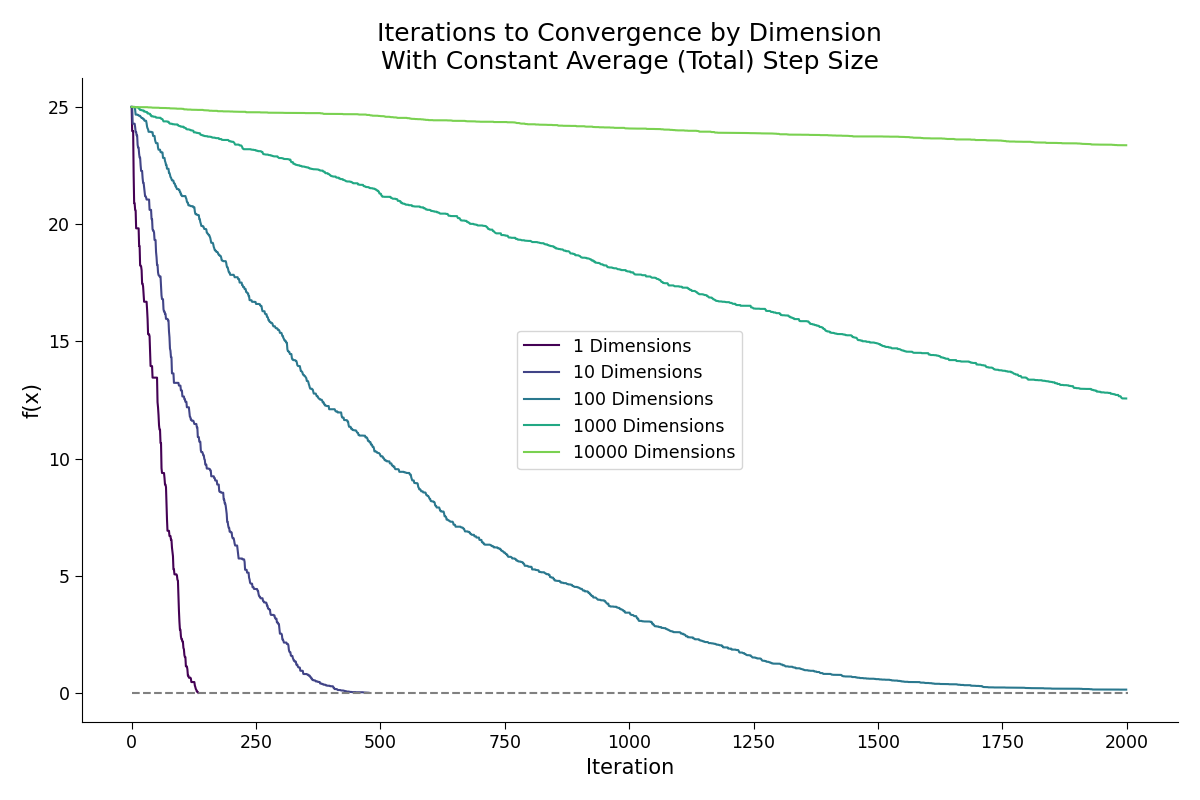

In [25]:
# @markdown **Run this cell** to see how iterations to convergence changes as the number of dimensions increases
def simple_quadratic(x):
  return np.dot(x,x)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

def fixed_scale_propose(x, step_size=0.1, rng=np.random.default_rng()):
  proposed_x = x + rng.standard_normal(size=x.shape) * step_size
  return proposed_x

# propose accept reject loop
step_size = 0.1
max_proposals = 2000
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size**2:
    proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color=colors[ii])
ax.hlines(step_size**2, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\nWith Constant Average (Total) Step Size')
ax.legend()

plt.show()

The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is

$$
\mathbf{x}_{\text{proposed}} = \mathbf{x}_{\text{current}} + \mathbf{\xi}
$$

with $\mathbf{\xi} \sim \sigma \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. The average size of a perturbation, i.e., its Euclidean length $\|\mathbf{\xi} \|$, is given by

$$ \begin{align}
\mathbb{E}[\|\mathbf{\xi} \|] &= \mathbb{E}\left[\sqrt{\sum_{i=1}^N \xi_i^2}\right] = \sigma \mathbb{E}[\chi_N] = \sigma \sqrt{2} \frac{\Gamma\left(\frac{N+1}{2}\right)}{\Gamma\left(\frac{N}{2}\right)} \\
&\approx \sigma \sqrt{N} \ \text{for large } N.
\end{align}$$

Here $\chi_N$ denotes a chi distribution with $N$ degrees of freedom, representing the distribution of the norm of a vector of $N$ independent standard normal random variables. ($\Gamma$ denotes the gamma function which is a generalization of the factorial function on integers to real and complex values.) For high dimensions, i.e., large $N$, the approximation $\sigma \sqrt{N}$ becomes increasingly accurate due to the central limit theorem.

Thus to have a consistent average proposal step length, $s$, we need to have $\sigma = \frac{s}{\sqrt{N}}$. If instead have a constant $\sigma$ as dimension increase, the average sizes of the steps will increase as the number of the dimensions increases. This is problematic as illustrated below.

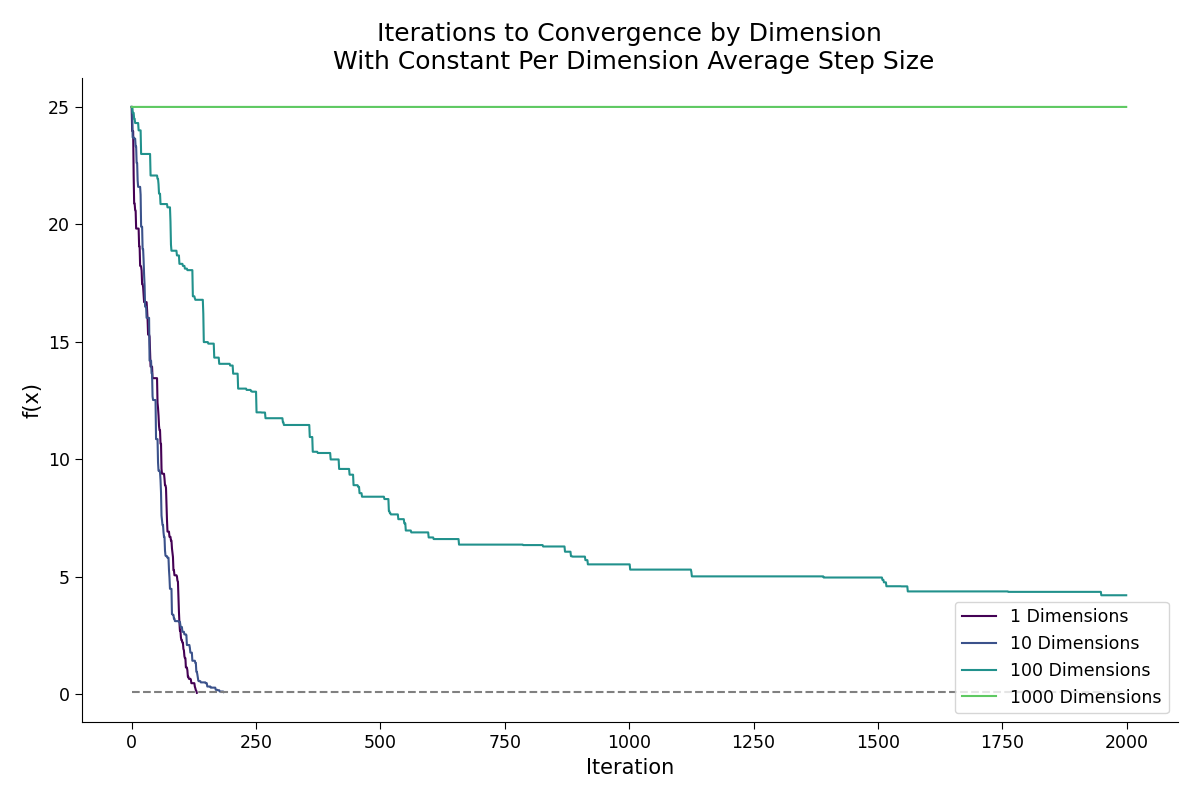

In [26]:
# @markdown **Run this cell** to see how having step size increase with dimension is a problem.
# propose accept reject loop
step_size = 0.1
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000] # number of dimensions
x_histories = []
z_histories = []
max_proposals = 2000
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    proposed_x = fixed_scale_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\n With Constant Per Dimension Average Step Size')
ax.legend()

plt.show()

Having step size scale up with dimension can lead to fast convergence at first (bigger step sizes means you get where you're going more quickly) but at some point large step sizes make it more difficult to zero in on the exact location of the optimal value. Larger step sizes limit percision, eventually to the point where no improvment is made.

Now that we've seen what increasing the number of dimensions does to convergence rate of propose-accept-reject, let's take a look at perturb-measure-step.

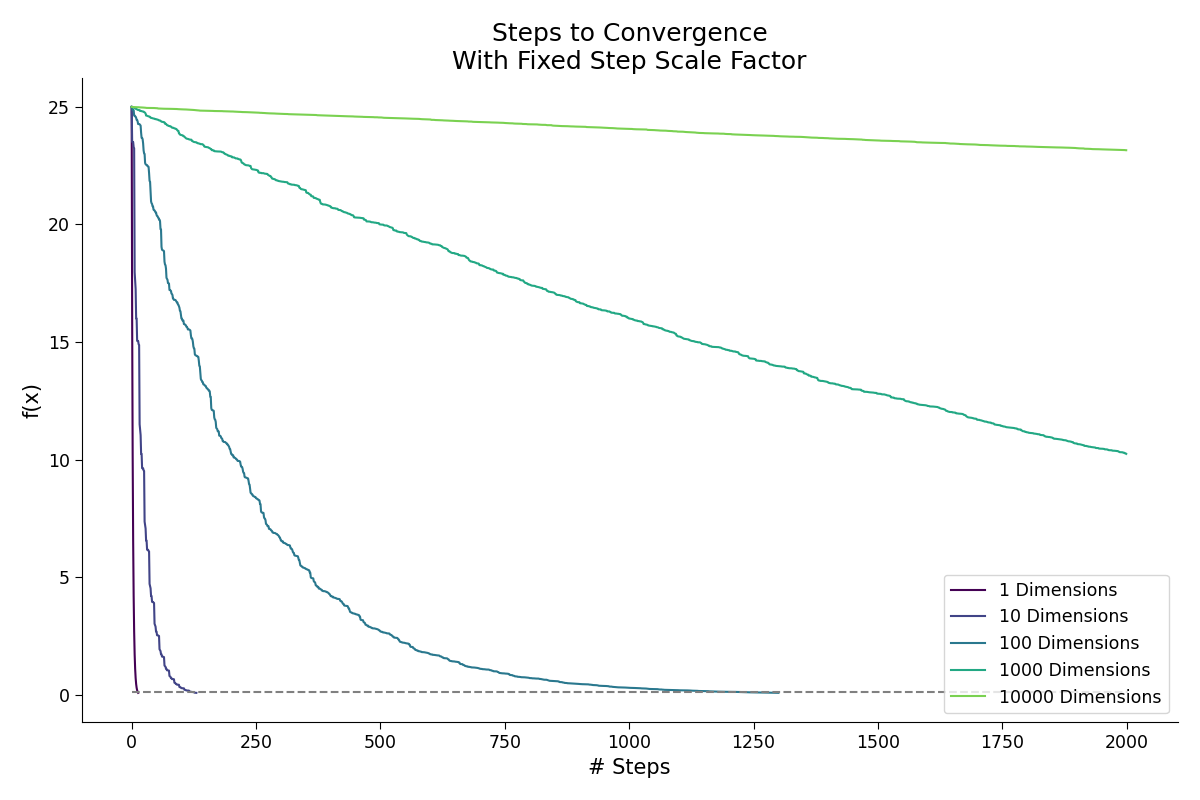

In [27]:
# @markdown **Run this cell** to look at convergence rates in different dimensions for perturb-measure-step
test_perturb = 0.00001
step_scale = 0.1
starting_distance_from_optimal = 5
pms_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
max_steps = 2000
for N in N_Dim:
  x_history = []
  z_history = []
  num_steps = 0
  num_function_evaluations = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  num_function_evaluations += 1
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    for dim in range(N):
      x[dim] += test_perturb #perturb
      z_test = simple_quadratic(x) #test
      x[dim] -= test_perturb # un-perturb
      dim_grad_est = (z_test - z) / test_perturb #measure slope
      x[dim] -= step_scale * dim_grad_est #step
      num_steps += 1
      z = simple_quadratic(x)
      num_function_evaluations += 2
      x_history.append(x)
      z_history.append(z)
      if num_steps > max_steps:
        break
    if num_steps > max_steps:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plot each dimensions history
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('# Steps')
ax.set_ylabel('f(x)')
ax.set_title('Steps to Convergence\nWith Fixed Step Scale Factor')
ax.legend()

plt.show()

The number of iterations here to convergence increases with dimension, partly because, this version of perturb-measure-step basically treats each dimension in isolation, so $N$ steps are required to make improvements in all $N$ dimensions. In the case above where we have 10,000 dimensions, but only run for 2000 steps, 8000 of the elements of $\mathbf{x}$ have been improved. Scale is important for the brain. Recall that there are trillions of synapses the brains of brainy animals. Learning in the brain is going to require optimzation algorithms that are still effective in high dimensions.

# 2.1.3.3 Perturb-Meausre-Step and Propose-Accept-Reject Are Always Slow in Higher Dimensions.

As mentioned before, comparing algorithms is notoriously difficult, so much can depend upon the specifics of the problems being used for comparison, and the interplay of the meta-parameters of the optimization algorithm with the specifics of the problem. To navigate through this potential noise, we're going to use an analytical approach. Our problem setup is as follows:

We consider a function \(f(\mathbf{x})\) that is *analytic*. This has a precise mathematical meaning, but intuitively it means that the function does not exhibit excessive local variability. More formally, an analytic function can be locally expressed by a convergent power series. For our purposes, this implies smoothness and the absence of abrupt changes in behavior, which in turn allows for reliable use of linear approximations in the vicinity of any point within its domain. Specifically, the function can be approximated as:

$$
f(\mathbf{x} + \mathbf{\delta}) \approx f(\mathbf{x}) + \mathbf{\delta} \cdot \mathbf{g})
$$

where $\mathbf{g} = \nabla f(\mathbf{x}) = \left. \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \dots, \frac{\partial f}{\partial x_n} \right)\right|_{\mathbf{x}}$ is the gradient of $f$ evalutated at $\mathbf{x}$, $\mathbf{\delta}$ is a small perturbation vector in $\mathbb{R}^n$, and $\mathbf{delta} \cdot \mathbf{g}$ is the inner product of the two vectors.
Note that the perturbation $\mathbf{\delta}$ must be sufficiently small. As $\|\mathbf{\delta}\|$ increases in magnitude, higher-order terms in the Taylor expansion of $f$ at $\mathbf{x}$ become significant, and the linear approximation becomes less accurate.

Okay so now we want to think about our two algorithms, propose-accept-reject and perturb-measure-step, and ask, for any analytic function, at any point $\mathbf{x}$, with a given step size $s$, what is the average expected improvement from a single interation of the algorithm, and how does this expected improvement compare to the 'best possible' improvement of taking a step in the direction of the gradient?



## Propose-accept-reject analysis
Let's start, propose-accept-reject goes first.

1. If we reject a proposal the improvement is zero.
2. If we accept a proposal, the direction of the proposed step was in the same half-space as the gradient.
3. The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is
$$
\mathbf{x}' = \mathbf{x} + \mathbf{\xi}
$$
with $\mathbf{\xi} \sim \frac{s}{\sqrt{n}} \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. We scale each perturbation by $\frac{s}{\sqrt{n}}$ so that $\mathbb{E}\left[\| \mathbf{\xi} \|\right] = s$.
4. We assume that $s$ is small enough, that the linear approximation is good, and the expected change in the function is then simply $$ \xi \cdot \mathbf{g}$$
5. Now we haven't said what $\mathbf{g}$ is or what $f$ is, so at first glance it may seem crazy to try and compute this, but we're about to do a sneaky math trick so pay attention. We're going to do a change of coordinates. $\mathbf{\xi}$ is basically a little Guassian cloud, and the density of this cloud is isotropic, that means the same in all radial dimensions, so that means that any rigid rotation of coordinates will leave the distribution unchanged. Okay, now $\mathbf{g}$ can be re-written as the product of a unit direction vector $\frac{\mathbf{g}}{\|\mathbf{g}\|}$ and a magnitude $\|\mathbf{g}\|$. Then we can shift our coordinates so that our first dimension is perfectly aligned with the gradient, and all other $n-1$ dimensions are perfectly unaligned with the gradient. In this new coordinate system $\mathbf{g} = \|\mathbf{g}\|(1, 0, \cdots, 0)$, and then the inner product of is simply $$(\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) \|\mathbf{g}\| = \xi_1 \|\mathbf{g}\|$$
6. Then $\mathbb{E}\left[\xi_1 | \text{Proposal Accepted} \right] = s \sqrt{\frac{2}{n \pi}}$, since the proposal will only be accepted if $\xi_1 > 0$, so conditional on acceptance $\xi_1$ follows a half-normal or $\chi_1$ distribution.
7. By the symetry of the normal distribution we also have that on average, half of the time proposals will be rejected and half of the time they will be accepted.
8. Putting this all together the expected rate of improvement per iteration of propose-accept-reject is
$$ \frac{s\|\mathbf{g}\|}{\sqrt{2\pi n}}$$

Now if we were to just know the direction of $\mathbf{g}$ and step $s$ in that direction, the improvement would be $s\|\mathbf{g}\|$. So we see that the rate of improvement relative to the optimally oriented small step is reduced by a factor of $\frac{1}{\sqrt{2 \pi n }}$. Intuitively as the number of dimensions increases, random step directions are less and less likely to be well aligned with this optimal direction. Note that if we were to use our 'always-step' variant of propose-accept-reject, we could do a little better with
$$ \frac{s\|\mathbf{g}\|\sqrt{2}}{\sqrt{\pi n}}$$ but we would still have our expected improvement per step drop of with $\frac{1}{\sqrt{n}}$

## Perturb-Measure-Step Analysis

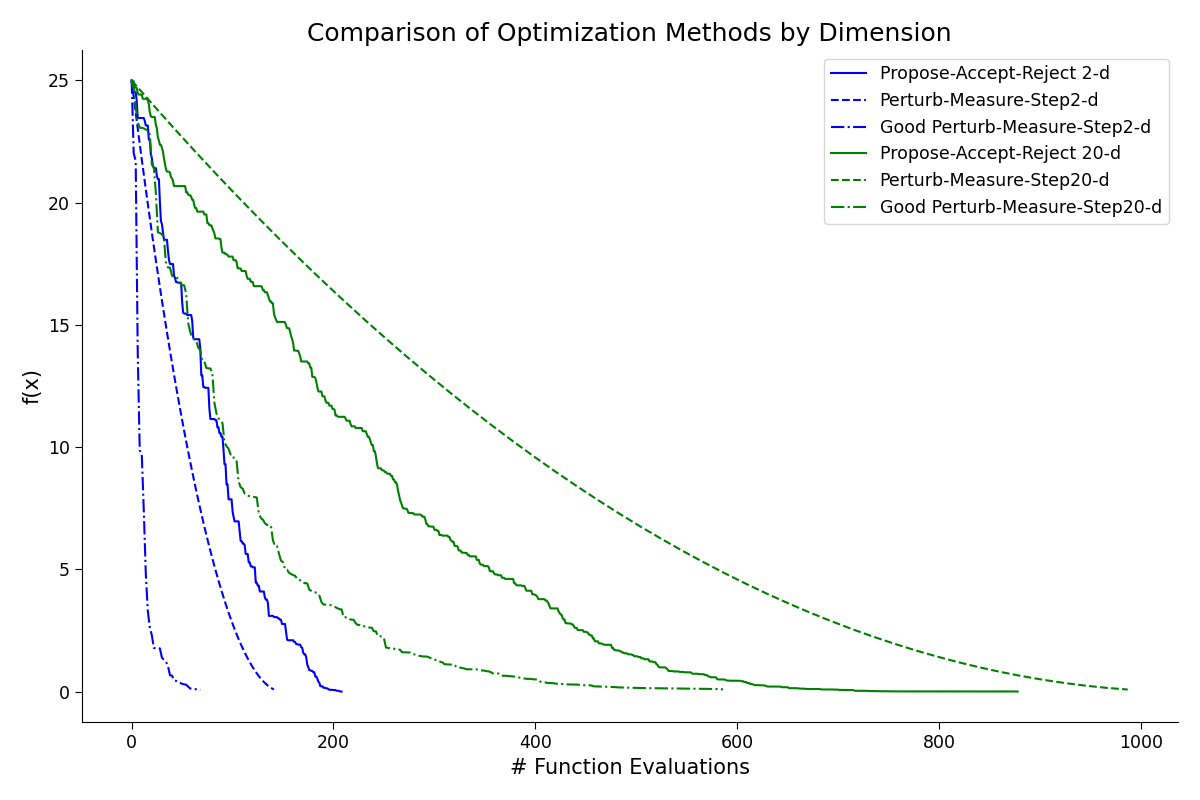

In [7]:
def simple_quadratic(x):
  return np.sum(x**2)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

# Propose-accept-reject loop
def propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal):
  par_rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = par_rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_proposed = 1
    while z > step_size**2 and len(z_history) < max_proposals:
      proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
      z_proposed = simple_quadratic(proposed_x)
      if z_proposed < z:
        x = proposed_x
        z = z_proposed
      z_history.append(z)
    histories.append(z_history)
  return histories

# Perturb-measure-step
def perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal):
  pms_rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = pms_rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    while z > step_scale and len(z_history) < max_steps:
      grad_est = np.zeros(N)
      for dim in range(N):
        x[dim] += test_perturb
        z_test = simple_quadratic(x)
        x[dim] -= test_perturb
        grad_est[dim] = (z_test - z) / test_perturb #measure slope
      grad_est = grad_est / np.linalg.norm(grad_est)
      x -= step_scale * grad_est #step
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def good_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal):
  gpms_rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = gpms_rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = gpms_rng.standard_normal(size=N)
      norm_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = norm_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * directional_grad_est * norm_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

# Parameters
N_Dim = [2, 20]
step_size = 0.1
max_proposals = 1500
max_steps = 500
starting_distance_from_optimal = 5
test_perturb = 0.00001
step_scale = 0.1

# Collect data
z_par_histories = propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)
z_pms_histories = perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
z_gpms_histories = good_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c']  # colors for different dimensions

for ii, N in enumerate(N_Dim):
  evals_per_step = N + 1
  z_par_vals = z_par_histories[ii]
  z_pms_vals = z_pms_histories[ii]
  z_gpms_vals = z_gpms_histories[ii]
  n_evaluations_pms = np.arange(0, evals_per_step * (len(z_pms_vals)), evals_per_step)
  # always just 2 evaluations per step for the chaotic-good perturb-measure-step
  n_evaluations_gpms = np.arange(0, 2 * (len(z_gpms_vals)), 2)
  ax.plot(np.arange(len(z_par_vals)), z_par_vals, f'{colors[ii]}-', label=f'Propose-Accept-Reject {N_Dim[ii]}-d')
  ax.plot(n_evaluations_pms, z_pms_vals, f'{colors[ii]}--', label=f'Perturb-Measure-Step{N_Dim[ii]}-d')
  ax.plot(n_evaluations_gpms, z_gpms_vals, f'{colors[ii]}-.', label=f'Good Perturb-Measure-Step{N_Dim[ii]}-d')

ax.set_xlabel('# Function Evaluations')
ax.set_ylabel('f(x)')
ax.set_title('Comparison of Optimization Methods by Dimension')
ax.legend()

plt.show()

So for a single dimension, the measuring approach is more efficeint, and as we will see this is the case for 2 dimensions as well, but as we move to higher dimensions just random propose and reject is actually faster. It seems like we are being to careful here. Is there some way to combine the best of both worlds, the random happy go lucky approach of propose and reject, but getting more information out of our function evaluations than just is this better, but using the info about how much better. Yes there is, it looks like this.

### Propose-Accept-Reject Method

The **propose-accept-reject** method is a stochastic optimization technique that iteratively proposes changes to a parameter vector and accepts these changes based on a simple comparison rule. Here’s how this method operates in detail:

1. **Initialization**:
   - Initialize the parameter vector $\mathbf{x} \in \mathbb{R}^n$.
   - Choose a step size $s$ for the perturbations.

2. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$ to establish a baseline for comparison.

   2. **Generate a Candidate Point**:
      - Sample a candidate point $\mathbf{x}' = \mathbf{x} + \frac{s}{\sqrt{n}} \cdot \mathcal{N}(0, \mathbf{I})$, where $\mathcal{N}(0, \mathbf{I})$ represents a standard, $n$-dimensional multivariate normal distribution. This perturbation adjusts the scale of the step size inversely with the square root of the dimensionality, keeping average step size roughly constant regardless of the number of dimensions.

   3. **Candidate Point Evaluation**:
      - Evaluate the function at the candidate point $f(\mathbf{x}')$.

   4. **Accept or Reject the Candidate**:
      - Compare the function values: if $f(\mathbf{x}') < f(\mathbf{x})$, then update $\mathbf{x} \leftarrow \mathbf{x}'$. This step implements the 'accept if better' rule, where only improvements lead to an update. (If we were minimizing we would use $f(\mathbf{x}') > f(\mathbf{x})$ as our acceptance criteria instead.)

   5. **Convergence Check**:
      - Repeat the loop until a convergence criterion is met. Criteria can include a maximum number of function evaluations, a maximum number of consecutive failed attempts at improvement, achievement of a target function value, or a combination of these factors.


### Sequential Perturb-Measure-Step Method

Sequential perturb-measure-step grew out of the idea of using more information from function evaluations. In one dimensional problems there was only on direction to make a perturbation. In two dimensions we alternated our test perturbations between the two dimensions sequentially.

A. **Initialization**:
   - Initialize the parameter vector $\mathbf{x} \in \mathbb{R}^n$.
   - Choose a test perturbation magnitude $s_{\text{test}}$ and a parameter step scaling size $s_x$.

B. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$ to establish a baseline.
   2. **Perturb Each Dimension Separately**:
      - For each dimension $i \in \{1, 2, \dots, n\}$:
        1. Generate a test point $\mathbf{x}' = \mathbf{x} + \mathbf{e}^i \cdot s_{\text{test}}$. Here, $\mathbf{e}^i$ is the standard orthonormal unit basis vector for the $i^{\text{th}}$ dimension.
        2. Evaluate the function at $\mathbf{x}'$.
        3. Estimate the rate of change in the $i^{\text{th}}$ dimension: $$ \hat{g}_i = \frac{f(\mathbf{x}') - f(\mathbf{x})}{s_{\text{test}}} $$
        4. Update $\mathbf{x} \leftarrow \mathbf{x} + \mathbf{e}^i \cdot \hat{g}_i \cdot s_x$.
        5. $s_{\text{test}}$
   3. **Convergence Check**:
      - Repeat the loop until a convergence criterion is met, such as a maximum number of function evaluations, a significant drop in improvement per iteration, achievement of a target function value, or a combination of these factors.

### Batch Perturb-Measure-Step Method

An alternative approach to the sequential perturb-measure-step method is to estimate changes in all dimensions before applying a single comprehensive update. This method can be more stable as it considers the cumulative gradient vector from all dimensions before making adjustments.

1. **Initialization**:
   - Similar to the sequential method.

2. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$.
   2. **Perturb and Measure in Batch**:
      - For each dimension $i \in \{1, 2, \dots, n\}$:
        1. Generate a test point $\mathbf{x}_{\text{test}} = \mathbf{x} + \mathbf{e}^i \cdot s$        
        2. Evaluate $f(\mathbf{x}_{\text{test}})$.
        3. Estimate the rate of change in the $i^{\text{th}}$ dimension: $$ \hat{g}_i = \frac{f(\mathbf{x}_{\text{test}}) - f(\mathbf{x})}{s_{\text{test}}} $$
   3. **Update Using the Complete Gradient Vector**:
      - Construct the gradient vector $\hat{\mathbf{g}} = (\hat{g}_1, \hat{g}_2, \dots, \hat{g}_n)$.
      - Update $\mathbf{x} \leftarrow \mathbf{x} + \hat{\mathbf{g}} \cdot s_x$.
   4. **Convergence Check**:
      - Similar to the sequential method.

The sequential and batch flavours of perturb-measure-step are roughly equivalent, though the batch version my help avoid some pathological cases that emerge for the sequential variant.



### Reckless-Perturb-Measure-Step Method

The perturb-measure-step variants described above, here after the **careful-perturb-measure-step** methods, are overly meticulous, evaluating each dimension separately and systematically. There is a better way which embraces chaotic power inherent in the **propose-accept-reject** method, while still extracting significant information from each function evaluation by measuring the rate of change. A we call the hybrid approach that achieves this **reckless-perturb-measure-step**.

The core idea is to randomly select a direction for testing the function's response, then based on the estimated rate of improvement in that direction within the parameter space, take a proportional step. Here's the process in detail:

1. **Initialization**:
   - Initialize the parameter vector $\mathbf{x} \in \mathbb{R}^n$.
   - Choose a test perturbation magnitude $s_{\text{test}}$ and a parameter step scaling size $s_x$.

2. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$.

   2. **Generate a Random Direction**:
      - Generate a raw random vector $\mathbf{v}$ from a standard, $n$-dimensional multivariate normal distribution $\mathcal{N}(0, \mathbf{I})$. This point sits in a 'Gaussian Cloud' around the orgin.
      - Normalize $\mathbf{v}$ to obtain a random unit vector $\mathbf{u} = \frac{\mathbf{v}}{\|\mathbf{v}\|}$. This point sits on the surface of a hyper-sphere of radius 1.

   3. **Test Point Evaluation**:
      - Generate a test point $\mathbf{x}' = \mathbf{x} + s_{\text{test}} \cdot \mathbf{u}$.
      - Evaluate the function at the test point $f(\mathbf{x}')$.

   4. **Measure Rate of Change**:
      - Calculate the rate of change of $f$ in the direction of $\mathbf{u}$ using the formula:
        $$\Delta f_{\mathbf{u}} = \frac{f(\mathbf{x}') - f(\mathbf{x})}{s_{\text{test}}}$$
        Because $\mathbf{u}$ is a unit vector, $s_{\text{test}}$ gives the 'run' in this 'rise over run' slope calculation.

   5. **Update Parameter Vector**:
      - Update $\mathbf{x}$ by moving in the direction of $\mathbf{u}$, scaled by the estimated rate of improvement and the step scaling size:
        $$\mathbf{x} \leftarrow \mathbf{x} + s_x \cdot \Delta f_{\mathbf{u}} \cdot \mathbf{u}$$

   6. **Convergence Check**:
      - Repeat the loop until a convergence criterion is met, such as a maximum number of function evaluations, a significant drop in improvement per iteration, achievement of a target function value, some combination of these factors, or even something else.

Let's compare the average improvement per step at a point for our simple quadratic function

In [8]:
import scipy.stats

def measure_step_improvement(initial_point, test_step_size, step_scale, num_samples=400, rng=None, plot=False):
    """
    Measure the average empirical improvement of a perturbation-based optimization method.
    Parameters:
    - initial_point (np.ndarray): Starting point in parameter space.
    - test_step_size (float): Magnitude of the perturbations applied.
    - step_scale (float): Scaling factor for step size based on the optimization feedback.
    - num_samples (int, optional): Number of perturbation samples.
    - rng (np.random.Generator, optional): Random number generator for reproducibility.
    - plot (bool, optional): If True, plot the histogram of empirical improvements.
    Returns:
    - tuple: Average empirical improvement, theoretical improvement, best possible improvement.
    """
    if rng is None:
        rng = np.random.default_rng()
    N = initial_point.shape[0]
    raw_perturbs = rng.standard_normal(size=(N, num_samples))
    unit_perturbs = raw_perturbs / np.linalg.norm(raw_perturbs, axis=0, keepdims=True)
    test_points = initial_point[:, np.newaxis] + test_step_size * unit_perturbs
    value_at_initial = simple_quadratic(initial_point)
    values_at_test_points = simple_quadratic(test_points)
    diffs = values_at_test_points - value_at_initial
    steps = diffs / test_step_size * step_scale
    new_points = initial_point[:, np.newaxis] + steps[np.newaxis, :] * unit_perturbs
    values_at_new_points = simple_quadratic(new_points)
    improvements = values_at_new_points - value_at_initial
    average_improvement = np.mean(improvements)
    gradient_at_initial = gradient_simple_quadratic(initial_point)
    theoretical_improvement = (np.linalg.norm(gradient_at_initial))**2 * step_scale * (1/N)
    best_possible_improvement = (np.linalg.norm(gradient_at_initial))**2 * step_scale
    if plot:
        plot_improvements(improvements, average_improvement, theoretical_improvement, best_possible_improvement)
    return average_improvement, theoretical_improvement, best_possible_improvement

def plot_improvements(improvements, average_improvement, theoretical_improvement, gradient_at_initial):
  max_possible_improvement = np.linalg.norm(gradient_at_initial)**2 * step_scale
  improvements_scaled = improvements / max_possible_improvement  # Scale based on the maximum possible improvement

  fig, ax = plt.subplots(figsize=(12, 8))
  n, bins, patches = ax.hist(improvements_scaled, bins=50, density=True, alpha=0.5, label='Scaled Empirical Improvements')
  scaled_theoretical_improvement = theoretical_improvement / max_possible_improvement
  scaled_average_improvement = average_improvement / max_possible_improvement

  ax.axvline(scaled_theoretical_improvement, color='r', linestyle='--', label='Scaled Theoretical Mean Improvement')
  ax.axvline(scaled_average_improvement, color='g', linestyle='--', label='Scaled Actual Mean Improvement')
  ax.set_xlabel('Scaled Improvement')
  ax.set_ylabel('Frequency')
  ax.legend()
  plt.show()

# Example usage
test_rng = np.random.default_rng(42)
measure_step_improvement(10 * test_rng.standard_normal(size=500), 0.0000001, 0.0001, num_samples=1000, plot=True)


IndexError: invalid index to scalar variable.

In [ ]:
def simple_quadratic(x):
  return np.sum(x * x, axis=0)

def gradient_simple_quadratic(x):
  return 2 * x

test_rng = np.random.default_rng(42)

def propose_accept_reject_average_improvement(x, step_size, num_samples=400, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  N = x.shape[0]
  stable_step_scale = step_size / np.sqrt(N)
  proposals = x[..., np.newaxis] + stable_step_scale * rng.standard_normal(size=(N, num_samples,))
  f_x = simple_quadratic(x)
  f_proposals = simple_quadratic(proposals)
  f_diff = f_proposals - f_x
  f_diff[f_diff < 0] = 0
  empirical_improvement = np.mean(f_diff)
  g_x = gradient_simple_quadratic(x)
  theoretical_improvement = np.linalg.norm(g_x) * stable_step_scale * np.sqrt(2/np.pi) * 0.5
  best_possible_improvement = np.linalg.norm(g_x) * step_size
  return empirical_improvement, theoretical_improvement, best_possible_improvement

propose_accept_reject_average_improvement(10 * test_rng.standard_normal(size=500), 0.0000001)

In [ ]:
def systematic_perturb_measure_step_average_improvement(x, test_scale, step_scale, num_samples=400, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  N = x.shape[0]
  perturbs = test_scale * np.eye(N)
  test_points = x[..., np.newaxis] + perturbs
  f_x = simple_quadratic(x)
  f_test_points = simple_quadratic(test_points)
  f_diffs = f_test_points - f_x
  f_steps = f_diffs / test_scale * step_scale
  new_xs = x[..., np.newaxis] + np.diag(f_steps) # N x N
  f_new_xs = simple_quadratic(new_xs)
  empirical_improvement = np.mean(f_new_xs - f_x)
  g_x = gradient_simple_quadratic(x)
  theoretical_improvement = (np.linalg.norm(g_x))**2 * step_scale * (1/N)
  best_possible_improvement = (np.linalg.norm(g_x))**2 * step_scale
  return empirical_improvement, theoretical_improvement, best_possible_improvement

systematic_perturb_measure_step_average_improvement(10 * test_rng.standard_normal(size=500), 0.0000001, 0.0001)

In [ ]:
def measure_step_improvement(initial_point, test_step_size, step_scale, num_samples=400, rng=None, plot=False):
  """
  Measure the average empirical improvement of a perturbation-based optimization method.
  Parameters:
  - initial_point (np.ndarray): Starting point in parameter space.
  - test_step_size (float): Magnitude of the perturbations applied.
  - step_scale (float): Scaling factor for step size based on the optimization feedback.
  - num_samples (int, optional): Number of perturbation samples.
  - rng (np.random.Generator, optional): Random number generator for reproducibility.
  - plot (bool, optional): If True, plot the histogram of empirical improvements.
  Returns:
  - tuple: Average empirical improvement, theoretical improvement, best possible improvement.
  """
  if rng is None:
    rng = np.random.default_rng()
  N = initial_point.shape[0]
  raw_perturbs = rng.standard_normal(size=(N, num_samples))
  unit_perturbs = raw_perturbs / np.linalg.norm(raw_perturbs, axis=0, keepdims=True)
  test_points = initial_point[:, np.newaxis] + test_step_size * unit_perturbs
  value_at_initial = simple_quadratic(initial_point)
  values_at_test_points = simple_quadratic(test_points)
  diffs = values_at_test_points - value_at_initial
  steps = diffs / test_step_size * step_scale
  new_points = initial_point[:, np.newaxis] + steps[np.newaxis, :] * unit_perturbs
  values_at_new_points = simple_quadratic(new_points)
  improvements = values_at_new_points - value_at_initial
  average_improvement = np.mean(improvements)
  gradient_at_initial = gradient_simple_quadratic(initial_point)
  theoretical_improvement = (np.linalg.norm(gradient_at_initial))**2 * step_scale * (1/N)
  best_possible_improvement = (np.linalg.norm(gradient_at_initial))**2 * step_scale
  if plot:
      plot_improvements(improvements, average_improvement, theoretical_improvement)
  return average_improvement, theoretical_improvement, best_possible_improvement

def plot_improvements(improvements, average_improvement, theoretical_improvement):
  fig, ax = plt.subplots(figsize=(12, 8))
  remove_ip_clutter(fig)
  n, bins, patches = ax.hist(improvements, bins=50, density=True, alpha=0.5, label='Empirical Improvements')
  ax.axvline(theoretical_improvement, label='Theoretical Mean Improvement', color='r', linestyle='--')
  ax.axvline(average_improvement, label='Actual Mean Improvement', color='g', linestyle='--')
  ax.set_xlabel('Improvement')
  ax.set_ylabel('Frequency')
  ax.legend()
  plt.show()

measure_step_improvement(10 * test_rng.standard_normal(size=500), 0.0000001, 0.0001, num_samples=1000, plot=True)

In [ ]:
import scipy.stats
def reckless_perturb_measure_step_average_improvement(x, test_step_size, step_scale, num_samples=400, rng=None, plot=False):
  if rng is None:
    rng = np.random.default_rng(42)
  N = x.shape[0]
  raw_perturbs = rng.standard_normal(size=(N, num_samples))
  unit_perturbs = raw_perturbs / np.linalg.norm(raw_perturbs, axis=0, keepdims=True)
  test_points = x[:, np.newaxis] + test_step_size * unit_perturbs
  f_x = simple_quadratic(x)
  f_test_points = simple_quadratic(test_points)
  f_diffs = f_test_points - f_x
  f_steps = f_diffs / test_step_size * step_scale
  new_xs = x[:, np.newaxis] + f_steps[np.newaxis,:] * unit_perturbs
  print(new_xs.shape)
  f_new_xs = simple_quadratic(new_xs)
  empirical_improvements = f_new_xs - f_x
  average_empirical_improvement = np.mean(empirical_improvements)
  g_x = gradient_simple_quadratic(x)
  theoretical_improvement = (np.linalg.norm(g_x))**2 * step_scale * (1/N)
  best_possible_improvement = (np.linalg.norm(g_x))**2 * step_scale
  if plot:
    fig, ax = plt.subplots(figsize=(12, 8))
    remove_ip_clutter(fig)
    ax.hist(empirical_improvements, bins=50, density=True, alpha=0.5, label='Empirical Improvements')
    ax.axvline(theoretical_improvement, label='Theoretical Mean Improvement', color='r', linestyle='--')
    ax.axvline(average_empirical_improvement, label='Actual Mean Improvement', color='g', linestyle='--')
    ax.set_xlabel('Improvement')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()
  return average_empirical_improvement, theoretical_improvement, best_possible_improvement

reckless_perturb_measure_step_average_improvement(10 * test_rng.standard_normal(size=500), 0.00000001, 0.000001, num_samples=10000, plot=True)

Another way of coneceptualizing this is as the projection of the gradient of $f$ onto the random direction  $$ \hat{\mathbf{g} \cdot \mathbf{u}} $$

In [ ]:
# Parameters
N_Dim = [1, 2, 4, 6]
step_size = 0.1
max_proposals = 1500
max_steps = 200
starting_distance_from_optimal = 5
test_perturb = 0.00001
step_scale = 0.1

# Collect data
z_par_histories = propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)
z_pms_histories = perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c']  # colors for different dimensions

for ii, N in enumerate(N_Dim):
  evals_per_step = N + 1
  z_par_vals = z_par_histories[ii]
  z_pms_vals = z_pms_histories[ii]
  n_evaluations = np.arange(0, evals_per_step * (len(z_pms_vals)), evals_per_step)
  ax.plot(np.arange(len(z_par_vals)), z_par_vals, f'{colors[ii]}-', label=f'Propose-Accept-Reject {N_Dim[i]}-d')
  ax.plot(n_evaluations, z_pms_vals, f'{colors[ii]}--', label=f'Perturb-Measure-Step{N_Dim[i]}-d')

ax.set_xlabel('# Function Evaluations')
ax.set_ylabel('f(x)')
ax.set_title('Comparison of Optimization Methods by Dimension')
ax.legend()

plt.show()

In [ ]:
def plot_samples(N_dimensions, step_size):
  stable_samples = [scale_stable_propose(np.zeros(N_dimensions, dtype=float), step_size) for _ in range(10000)]
  fixed_scale_samples = [fixed_scale_propose(np.zeros(N_dimensions, dtype=float), step_size) for _ in range(10000)]

  norm_stable_samples = [np.sqrt(np.sum(s_**2)) for s_ in stable_samples]
  norm_fixed_scale_samples = [np.sqrt(np.sum(s_**2)) for s_ in fixed_scale_samples]

  plt.figure(figsize=(6, 4))
  plt.hist(norm_stable_samples, bins=100, alpha=0.5, label='Scale-Stable')
  plt.hist(norm_fixed_scale_samples, bins=100, alpha=0.5, label='Fixed-Scale')
  plt.legend()
  plt.show()
# Create interactive widgets
interactive_plot = widgets.interactive(plot_samples, N_dimensions=(1, 50), step_size=(0.01, 1.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '250px' # Adjust the plot height
interactive_plot

In [ ]:
# @title Stepping Through Optimization with Propose and Reject
# @markdown **Run this cell** to step through finding the minimum of a 2-d quadratic function using propose and reject.
class InteractivePolynomialProposeReject:
  def __init__(self,
               a = 6,
               b = 3,
               c = 3,
               x_bounds=(0, 8),
               y_bounds=(0, 8),
               step_size=0.2, seed=None):
    self.a = a
    self.b = b
    self.c = c
    self.x_bounds = x_bounds
    self.y_bounds = y_bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = 2.0
    self.current_y = 1.0
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.x_history = []
    self.y_history = []
    self.z_history = []
    self.rejected_x = []
    self.rejected_y = []
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept', disabled=True)
    self.reject = widgets.Button(description='Reject', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    self.show_rejected = widgets.Checkbox(value=True, description='Show Rejected')
    self.in_loop = False
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.accept, self.reject]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.reset, self.show_history, self.show_rejected])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_rejected.observe(self.on_show_rejected_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = self.eval_function(X, Y)
    # Initial plot commands return line objects, keep references to them
    self.contours = self.ax.contour(X, Y, Z, cmap='viridis')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'go', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.points_rejected, = self.ax.plot([], [], 'kx', label='Rejected')  # Empty data to start
    self.ax.legend()
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def eval_function (self, x, y, a=None, b=None, c=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    if c is None:
      c = self.c
    return a*(x-b)**2 + a*(y-b)**2 - c*x*y

  def on_propose_clicked(self, button):
    self.total_proposals += 1
    self.current_proposals += 1
    self.averaverage_proposals = self.acceptance_count / self.total_proposals
    perturbation_x, perturbation_y = self.rng.standard_normal(size=2) * self.step_size
    self.proposed_x = self.current_x + perturbation_x
    self.proposed_y = self.current_y + perturbation_y
    self.proposed_z = self.eval_function(self.proposed_x, self.proposed_y)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    with self.narration_display:
      clear_output()
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}, z: {self.current_z}')
      print("Click 'Accept' or 'Reject' to accept or reject this proposed x,y?")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = False
      self.reject.disabled = False
      self.propose.disabled = True
      self.full_step.disabled = True

  def on_accept_clicked(self, button):
    self.acceptance_count += 1
    self.current_proposals = 0
    with self.narration_display:
      clear_output()
      print(f'Accepted x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
      print(f'Average proposals per step: {self.total_proposals / self.acceptance_count:.3f}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.z_history.append(self.current_z)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.current_z = self.proposed_z
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.rejected_x = []
    self.rejected_y = []
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data([], [])
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False

  def on_reject_clicked(self, button):
    self.rejected_x.append(self.proposed_x)
    self.rejected_y.append(self.proposed_y)
    with self.narration_display:
      clear_output()
      print(f'Rejected x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f' Keeping x: {self.current_x:.3f}, y: {self.current_y:.3f}, z: {self.current_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
    self.proposed_x = None
    self.proposed_y = None
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data(self.rejected_x, self.rejected_y)
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False

  def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.full_step.disabled = True
    self.on_propose_clicked(button)
    if self.proposed_z < self.current_z:
        self.on_accept_clicked(button)
    else:
        self.on_reject_clicked(button)
    if not self.in_loop:
      self.full_step.disabled = False

  def on_take_10_steps_clicked(self, button):
    self.take_10_steps.disabled = True
    self.propose.disabled = True
    self.accept.disabled = True
    self.reject.disabled = True
    self.full_step.disabled = True
    self.in_loop = True
    for _ in range(10):
      self.on_full_step_clicked(button)
      self.fig.canvas.draw()
      time.sleep(0.6)
    self.in_loop = False
    self.take_10_steps.disabled = False
    self.propose.disabled = False
    self.full_step.disabled = False

  def on_reset_clicked(self, button):
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.current_x = self.rng.uniform(self.x_bounds[0], self.y_bounds[1])
    self.current_y = self.rng.uniform(self.y_bounds[0], self.y_bounds[1])
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.x_history = []
    self.y_history = []
    self.z_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_rejected_toggled(self, change):
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.fig.canvas.draw_idle()


ippr = InteractivePolynomialProposeReject()
display(ippr.fig.canvas)
clear_output()
display(ippr.ui)

Depending on the shape of the function, and the initial starting point, this can work pretty well, but as in the one dimensional case there may potentially be a lot of proposals that lead to no improvement. For this particular function, which is relatively simple, propose and reject will end up accepting roughly half of the proposals, however for more exotically shaped functions this acceptance rate can be much lower. For example, if the current point is in a narrow valley, with only a very gentle downward slope, but very steep sides, then there are relatively few directions that will lead to lower values, really only steps that are oriented with this valley. Thus, once the process is in such a location we expect there to be relatively many proposals for every step taken. And, as in the one dimensional case, because we simply either accept or reject, these rejected proposal points do nothing further to guide our search for the minimizing $x$ and $y$ values, so in a sense each rejected proposal is wasted computation. In the one dimensional case we used a pertrub-measure-step approach to overcome the computational waste of rejected proposals, so that on each function evaluation we were able to make progress towards better parameter values. Now let's see what the perturb measure step approach looks like in two dimensions.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.2.3 Optimizing a Two Dimensional Function with Perturb-Measure-Step

In [ ]:
# @title Optimization with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the minimum of 2-d quadratic function using a perturb-measure-step approach.
class InteractivePolynomialSlopeStepper:
  def __init__(self,
               a=6.0, b=3.0, c=3.0,
               x_bounds=(2, 6),
               y_bounds=(2, 6),
               test_step_size=0.025,
               param_step_size=0.025,
               adjustable_step_size=False,
               seed=None):
    #constants
    self.a, self.b, self.c = a, b, c
    self.x_bounds, self.y_bounds = x_bounds, y_bounds
    #state
    self.current_x = 3.0
    self.current_y = 2.5
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.test_x, self.test_y, self.test_z = None, None, None
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_history, self.y_history, self.z_history = [], [], []
    self.total_function_evaluations = 1
    self.num_steps = 0
    #buttons
    self.test_step_slider = widgets.FloatSlider(
        value=test_step_size, min=-0.5, max=0.5, step=0.01,
        description='Test Size:', readout=True, readout_format='.2f')
    self.param_step_slider = widgets.FloatSlider(
        value=param_step_size, min=0.01, max=1.5, step=0.01,
        description='Step Size:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.perturb_x = widgets.Button(description='Perturb x')
    self.measure_x = widgets.Button(description='Measure x', disabled=True)
    self.step_x = widgets.Button(description='Step x', disabled=True)
    self.perturb_y = widgets.Button(description='Perturb y')
    self.measure_y = widgets.Button(description='Measure y', disabled=True)
    self.step_y = widgets.Button(description='Step y', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    #bind buttons to action to handlers
    self.perturb_x.on_click(self.on_perturb_clicked)
    self.measure_x.on_click(self.on_measure_clicked)
    self.step_x.on_click(self.on_step_clicked)
    self.perturb_y.on_click(self.on_perturb_clicked)
    self.measure_y.on_click(self.on_measure_clicked)
    self.step_y.on_click(self.on_step_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.param_step_slider.observe(self.on_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')
    #ui setup
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb_x, self.measure_x, self.step_x]),
        widgets.HBox([self.perturb_y, self.measure_y, self.step_y]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.x_test_step_slider, self.x_step_slider]),
        widgets.HBox([self.y_test_step_slider, self.y_step_slider]),
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb_x, self.measure_x, self.step_x]),
        widgets.HBox([self.perturb_y, self.measure_y, self.step_y]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.reset, self.show_history])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

  def eval_function(self, x, y, a=None, b=None, c=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    if c is None:
      c = self.c
    return a * (x - b)** 2 + a * (y-b)**2 - c * y * x

  def init_plot(self):
    self.fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    self.ax_c = axs[1, 0]  # Contour plot axis
    self.ax_x = axs[0, 0]  # z(x), shares contour x-axis
    self.ax_y = axs[1, 1]  # z(y), shares contour y-axis
    self.ax_legend = axs[0, 1]  # Reserved for the legend
    self.ax_x.sharex(self.ax_c)
    self.ax_y.sharey(self.ax_c)
    # Contour Plot
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = self.eval_function(X, Y)
    self.contours = self.ax_c.contour(X, Y, Z, cmap='viridis')
    self.point_current, = self.ax_c.plot([self.current_x],
        [self.current_y], 'bo', label='Current')
    self.vline_current, = self.ax_c.plot([self.current_x, self.current_x],
                                         self.y_bounds, 'k--', alpha=0.3)
    self.hline_current, = self.ax_c.plot(self.x_bounds, [self.current_y, self.current_y],
                                         'k--', alpha=0.3)
    self.point_proposed, = self.ax_c.plot([], [], 'go',
                                          label='Proposed')
    self.points_history, = self.ax_c.plot([], [], 'ks', alpha=0.5,
                                        label='History', markersize=4)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)

    #self.ax_x.set_xlabel('x')
    self.ax_x.set_ylabel('z')
    self.ax_c.set_ylabel('y')
    self.ax_c.set_xlabel('x')
    #self.ax_y.set_ylabel('y')
    self.ax_y.set_xlabel('z')

    # Adjust visibility of shared axis tick labels
    plt.setp(self.ax_x.get_xticklabels(), visible=False)
    plt.setp(self.ax_y.get_yticklabels(), visible=False)

    # Initial empty plots for marginal plots; they will be updated dynamically
    self.curve_z_of_x, = self.ax_x.plot([], [], 'r-', label='z(x) with y fixed')
    self.curve_z_of_y, = self.ax_y.plot([], [], 'b-', label='z(y) with x fixed')
    self.x_slope_line, = self.ax_x.plot([], [], 'g-')
    self.y_slope_line, = self.ax_y.plot([], [], 'g-')
    self.x_proposed_line, = self.ax_x.plot([], [], 'g--', alpha=0.5)
    self.y_proposed_line, = self.ax_y.plot([], [], 'g--', alpha=0.5)
    self.current_xz, = self.ax_x.plot([], [], 'bo')
    self.current_yz, = self.ax_y.plot([], [], 'bo')
    self.test_x_point, = self.ax_x.plot([], [], 'rx')
    self.test_y_point, = self.ax_y.plot([], [], 'rx', label='Test')
    self.xz_proposed_point, = self.ax_x.plot([], [], 'go')
    self.yz_proposed_point, = self.ax_y.plot([], [], 'go')
    self.update_z_of_x()
    self.update_z_of_y()
    self.ax_legend.axis('off')
    handles, labels = [], []
    for ax in [self.ax_c, self.ax_x, self.ax_y]:
      for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
    self.ax_legend.legend(handles, labels, loc='center')
    plt.tight_layout()
    self.fig.canvas.draw_idle()

  def update_z_of_x(self, fixed_y=None):
    if fixed_y is None:
      fixed_y = self.current_y
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    z_vals = self.eval_function(x_vals, np.full_like(x_vals, fixed_y))
    self.curve_z_of_x.set_data(x_vals, z_vals)
    self.current_xz.set_data([self.current_x], [self.current_z])
    min_z, max_z = z_vals.min(), z_vals.max()
    padding = (max_z - min_z) * 0.04
    self.ax_x.set_ylim(min_z - padding, max_z)

  def update_z_of_y(self, fixed_x=None):
    if fixed_x is None:
      fixed_x = self.current_x
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    z_vals = self.eval_function(np.full_like(y_vals, fixed_x), y_vals)
    self.curve_z_of_y.set_data(z_vals, y_vals)
    self.current_yz.set_data([self.current_z], [self.current_y])
    min_z, max_z = z_vals.min(), z_vals.max()
    padding = (max_z - min_z) * 0.04
    self.ax_y.set_xlim(min_z - padding, max_z)

  def update_measure_x(self):
    rise = self.test_z - self.current_z
    run = self.test_x - self.current_x
    self.x_slope = rise / run
    self.xz_intercept = self.current_z - self.x_slope * self.current_x
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    z_vals = self.x_slope * x_vals + self.xz_intercept
    self.x_slope_line.set_data(x_vals, z_vals)
    self.proposed_x = self.current_x - self.param_step_slider.value * self.x_slope
    self.step_xz = self.xz_intercept + self.x_slope * self.proposed_x
    self.xz_proposed_point.set_data([self.proposed_x], [self.step_xz])
    z_min, z_max = self.ax_x.get_ylim()
    self.x_proposed_line.set_data([self.proposed_x, self.proposed_x], [z_min, z_max])
    if self.proposed_y is None:
      self.point_proposed.set_data([self.proposed_x], [self.current_y])
    else:
      self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()

  def update_measure_y(self):
    rise = self.test_z - self.current_z
    run = self.test_y - self.current_y
    self.y_slope = rise / run
    self.yz_intercept = self.current_z - self.y_slope * self.current_y
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    z_vals = self.y_slope * y_vals + self.yz_intercept
    self.y_slope_line.set_data(z_vals, y_vals)
    self.proposed_y = self.current_y - self.param_step_slider.value * self.y_slope
    self.step_yz = self.yz_intercept + self.y_slope * self.proposed_y
    self.yz_proposed_point.set_data([self.step_yz], [self.proposed_y])
    z_min, z_max = self.ax_y.get_xlim()
    self.y_proposed_line.set_data([z_min, z_max], [self.proposed_y, self.proposed_y])
    if self.proposed_x is None:
      self.point_proposed.set_data([self.current_x], [self.proposed_y])
    else:
      self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button, axis=None):
    # are we perturbing x or y use axis or infer from button description
    if axis is None:
      if button.description == 'Perturb x':
        axis = 'x'
      elif button.description == 'Perturb y':
        axis = 'y'
      else:
        raise ValueError("Invalid button description, expected 'Perturb x' or 'Perturb y'")
    if axis == 'x':
      self.test_x = self.current_x + self.test_step_slider.value
      self.test_y = self.current_y
      axis_is = 'x'
    elif axis == 'y':
      self.test_y = self.current_y + self.test_step_slider.value
      self.test_x = self.current_x
      axis_is = 'y'
    else:
      raise ValueError("Invalid axis, expected 'x' or 'y'")
    # calculate test value
    self.test_z = self.eval_function(self.test_x, self.test_y)
    self.total_function_evaluations += 1
    if axis == 'x':
      self.test_x_point.set_data([self.test_x], [self.test_z])
      self.measure_x.disabled = False
      self.perturb_x.disabled = True
      self.perturb_y.disabled = True
    elif axis == 'y':
      self.test_y_point.set_data([self.test_z], [self.test_y])
      self.measure_y.disabled = False
      self.perturb_y.disabled = True
      self.perturb_x.disabled = True
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test point: x = {self.test_x:.3f}, y = {self.test_y:.3f}, z = {self.test_z:.3f}.')
      print(f"Click 'Measure' to propose a new {axis_is} value based on this test point.")

  def on_measure_clicked(self, button, axis=None):
    if axis is None:
      if button.description == 'Measure x':
        axis = 'x'
      elif button.description == 'Measure y':
        axis = 'y'
      else:
        raise ValueError("Invalid button description, expected 'Measure x' or 'Measure y'")
    if axis == 'x':
      self.update_measure_x()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of x slope, proposed x step from {self.current_x:.3f} to {self.proposed_x:.3f}')
        print("Click 'Step x', to make the step.")
      self.step_x.disabled = False
      self.measure_x.disabled = True
    else: # axis == 'y':
      self.update_measure_y()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of y slope, proposed y step from {self.current_y:.3f} to {self.proposed_y:.3f}')
        print("Click 'Step y', to make the step.")
        self.step_y.disabled = False
        self.measure_y.disabled = True

  def on_step_clicked(self, button):
    self.num_steps += 1
    if self.proposed_x is None and self.proposed_y is None:
      raise ValueError("At least one of proposed x and y values must be set before stepping.")
    if self.proposed_x is None:
      self.proposed_x = self.current_x
    if self.proposed_y is None:
      self.proposed_y = self.current_y
    new_z = self.eval_function(self.proposed_x, self.proposed_y)
    self.total_function_evaluations += 1
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x = {self.proposed_x:.3f}, y = {self.proposed_y:.3f}, z = {new_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Total function evaluations so far: {self.total_function_evaluations}')
      print(f'Total number of steps taken so far: {self.num_steps}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.z_history.append(self.current_z)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.current_z = new_z
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_x, self.test_y, self.test_z = None, None, None
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()
    self.step_x.disabled = True
    self.step_y.disabled = True
    self.perturb_x.disabled = False
    self.perturb_y.disabled = False
    self.full_step.disabled = False
    self.take_10_steps.disabled = False

  def on_step_slider_changed(self, change):
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    if self.step_x is not None:
      rise = self.test_y - self.current_y
      run = self.test_x - self.current_x
      self.slope = rise / run
      self.y_intercept = self.current_y - self.slope * self.current_x
      x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      y_vals = self.slope * x_vals + self.y_intercept
      self.step_line.set_data(x_vals, y_vals)
      self.step_x = self.current_x + self.x_step_slider.value * self.slope
      self.step_y = self.slope * self.step_x + self.y_intercept
      self.step_point.set_data([self.step_x], [self.step_y])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_full_step_clicked(self, button):
    self.on_perturb_clicked(button, axis='x')
    self.on_measure_clicked(button, axis='x')
    self.on_step_clicked(button)
    self.on_perturb_clicked(button, axis='y')
    self.on_measure_clicked(button, axis='y')
    self.on_step_clicked(button)

  def on_take_10_steps_clicked(self, button):
    for _ in range(10):
      self.on_full_step_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Randomizing initial x and y values.')
    self.current_x = self.rng.uniform(self.x_bounds[0], self.x_bounds[1])
    self.current_y = self.rng.uniform(self.y_bounds[0], self.y_bounds[1])
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_x, self.test_y, self.test_z = None, None, None
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.x_history, self.y_history, self.z_history = [], [], []
    self.points_history.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipss = InteractivePolynomialSlopeStepper()
display(ipss.fig.canvas)
clear_output()
display(ipss.ui)

So for this particular function, with this particular starting point, and these step sizes, the perturb-measure-step approach is a bit more effective. Specifically, when we start at the same spot and using similar step sizes, we are able to zero in on the minimum of the curve with fewer function evaluations using perturb-measure-step than with propose and reject. However, as we will see in the next section this efficinecy is highly contingent on the particulars of the problem. Perhaps surprisingly, propose and reject will ultimately be more efficeint (in terms of average improvement per fucntion evaluation) than perturb-measure-step. For now though, let's see if we can apply these methods to our simple strike-no-strike problem where a lurk and strike predator must choose between striking and not strkining based on the activation level of a single sensory neuron.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")


#2.1.2.4: An Artificial Neural Network Model of Striking Behaviour

In the previous sequence we introduced a visual binary classification problem in which a lurking predator must choose between striking and not striking based on sensory input. The basic problem is simple. Given a sensory input pattern, in this case the intensity of a single pixel ranging from -6 to 6, determine whether to strike or not. The 'environment' of the organism consists of a data-set. There are 1125 elements in this particular data set. Each element is an $(x,y)$ pair, where $x$ is the sensory input the organism recieves, and $y$ is the correct action the organism should take. In the version of the problem we work with the organism gains a reward point if it strikes when prey is present, loses a reward point if it strikes when prey is not present, and obtains no reward if it does not strike (whether or not prey was present). You can try out this discrimination task for yourself by running the code cell below.


In [ ]:
# @markdown **Run this cell** to try out the 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_01_imp = InteractiveMNISTPredator(features=X_simple_1_feature,
                                           labels=y1_simple, feedback_type='both')
display(scramble_01_imp.fig.canvas)
clear_output()
display(scramble_01_imp.ui)

As we saw in the previous sequence, the simple association - strike when the center pixel is relatively light, don't strike when the center pixel is dark - works well. Previously we implemented this decision rule, i.e. policy, as a simple threshold. Now, instead we will implement a decision rule using a very simple (2-parameter) artificial neural network. (Recall that the dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49). We used this data set in the last sequence, and spent some time going over the structure of the data. The next few code cells repeat the over-view of the data from the previous sequence, as a reminder of what the data looks like.

In [ ]:
# What is the shape and type of the data we have to work with
print(f'')
print(f'Input data type: {type(X_simple_1_feature)}')
print(f'Input data shape: {X_simple_1_feature.shape}')
print(f'Output target data type: {type(y1_simple.dtype)}')
print(f'Output target shape: {y1_simple.shape}')

This data set consist of 1125 distinct $(\text{input}, \text{output})$ pairs. The goal of the organism is to learn as quickly as possible to correctly distinguish between these two different kinds of situation.

In [ ]:
# What do the ouptus look like, what is their range
print(y1_simple[:10])
print(f'max output value: {np.max(y1_simple)}')
print(f'min output value: {np.min(y1_simple)}')

In the interactive strike-no-strik setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [ ]:
# What do the inputs look like, what is there range
print(X_simple_1_feature[:10])
print(f'Max input value: {np.max(X_simple_1_feature)}')
print(f'Min input value: {np.min(X_simple_1_feature)}')

In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker center pixels. Now that we have a sense of the type and range of the input and output pairs let's visualize the whole dataset. For a simple dataset like this we can visualize the distribution of the input values conditional on the two different "correct" outputs

In [ ]:
# For scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
remove_ip_clutter(fig)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

In the previous sequence we were able to dial in an optimal threshold value. You can do that again if you'd like by running the code cell below and interacting with the widget.

In [ ]:
# @title Dialing in The Optimal Threshold
# @markdown **Run this cell** to dial in the optimal threshold
class InteractiveThresholdDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.threshold_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Threshold:', readout=True, readout_format='.2f')
    self.fig, (self.hist_ax, self.r_ax) = plt.subplots(2, 1, figsize=(8, 6),
                                                       sharex=True)
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([self.threshold_slider, self.narration_display])
    ])
    self.threshold_slider.observe(self.on_threshold_slider_changed, 'value')
    print("We have narration display", hasattr(self, 'narration_display'))


  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
      # for single threshold evaluations
      num_correct_strikes = np.sum(correct_strikes)
      num_false_strikes = np.sum(false_strikes)
      num_correct_non_strikes = np.sum(correct_non_strikes)
      num_false_non_strikes = np.sum(false_non_strikes)
      # Prepare a text-based confusion matrix
      confusion_matrix_data = [
          ["Should Strike", num_correct_strikes, num_false_non_strikes],
          ["Should Not Strike", num_false_strikes, num_correct_non_strikes]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for threshold {t[0][0]:.2f}:\n{confusion_matrix_table}\n\nTotal Reward: {r}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return r

  def on_threshold_slider_changed(self, change):
    self.plot_threshold(self.threshold_slider.value)
    self.fig.canvas.draw_idle()

  def plot_threshold(self, t):
    r = self.eval_threshold(t)
    self.threshold_vline.set_data([t, t], [0, r])
    y_min, y_max = self.hist_ax.get_ylim()
    self.hist_vline.set_data([t, t], [y_min, y_max])

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.threshold_vline, = self.r_ax.plot([],[] ,color='r', linestyle='--', label='Threshold')
    self.hist_vline, = self.hist_ax.plot([], [], color='r', linestyle='--', label='Threshold')
    self.reward_curve, = self.r_ax.plot(t_vals, r_vals, alpha=1.0, label='Expected Reward')
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='No Strike')
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')

    self.fig.suptitle('Threshold Evaluation')
    self.r_ax.set_xlabel('Threshold')
    self.r_ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.plot_threshold(self.threshold_slider.value)
    self.hist_ax.legend()
    self.r_ax.legend()
    self.fig.canvas.draw_idle()



itd = InteractiveThresholdDialer()
display(itd.fig.canvas)
clear_output()
display(itd.ui)

That was our threshold rule. This threshold rule works well, but as we can see in the widget above, the expected reward for a given threshold is a step function the threshold (this largely stems from the fact that reward is determined by performance over a finite and discrete data set.) This flatness of the reward function with respect to changes in the threshold made it difficult for our propose and reject method as we needed big proposal jumps to step over flat regions, but then we potentially spent lots of time overshooting the peak. This flatness was even more problematic for our perturb-measure-step rule, since perturb-measure-step relied upon estimating the slope of the reward function based on a small perturbation. However, the slope is flat at most points on this curve, so this pertubation approach does not not provide any useful information to guide parameter updates, unless of course perturbations are large enough that that span the width of the steps in this step function, but having such large steps introduces a host of other issues.

As we will see here (and many times throughout the book) stochasticity can provide a kind "fuzzing" effect, a softening of the hard edges of step-wise functions like this. Note that stochasticity might be introduced both through the behaviour of the organism (e.g. it strikes with a probability determined by its sensory inputs), or in the nature of the environment, (e.g. instead of computing the reward based on a finite and discrete set of 1125 input-output pairs in our dataset, we could instead have the reward be determined a random sample from a continuous distribution of input-output pairings. In either of these cases a decision rule with the exact same parameters may potentially yeild different amounts of reward on different 'runs' of the game, i.e. reward will be a random variable. In this case we shift our focus to maximising total expected reward, i.e. the average reward the organism would recieive over many iterations of the game. Note that in an evolutionary context, expected fitness is roughly what is being "optimized" for, but note that simply maximizing the expected "score" in many of the sub games of life, e.g. eating food, not being eaten, finding mates, etc. will not be what maximizes fitness. See sequence P1C3_S3). For now we'll leave our environment as totally deterministic, and introduce stochasticity into the behaviour of the organism. This will come quite naturally out of our (very simple) artifical neural network, or 'connectionist', decision rule.

As inspiration for our decision rule we imagine a very simple organism. One that has a single sensory input neuron, in turn connected to a single output neuron by single synaptic weight. If the output neuron fires (spikes) the predator strikes, and if it does not fire the predator does not strike.

We model this creature's sensory-behaviour system as follows. Let $x$ be the raw sensory input (scalar) in a given episode. We imagine that $x$ corresponds to the activation level and firing rate of a single photosensitive neuron. This input neuron is then connected by a synapse to a single output neuron. The activation level of this output neuron is computed as
$$y = wx + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron and $w$ is the strength of the synaptic weight between the input neuron and the output neuron. Is this case there is only one output and one input so $w$ is a scalar. In cases with multiple inputs and outputs we would use $\mathbf{W}$ to denote the matrix of such synaptic weights between all inputs and outputs and $\mathbf{x}$ to denote the vector of sensory inputs. (A quick notation reminder: bold lowercase letters typically represent column vectors, bold uppercase letters typically denote matrices or higher-order tensors.) We imagine that the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Here $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

--Picture of this very simple neural circuit here--

**Quick Math Exercise: The Connection Between Softmax Normalization and the Standard Logistic Sigmoid.**

Consider a random variable with two possible outcomes, $A$ and $B$. The probability of each outcome is determined by applying the softmax function to their respective scores, $a$ and $b$. Specifically, the probability of outcome $A$ occurring is given by the softmax formula:
$$ \Pr \{A\} = \frac{e^a}{e^a + e^b}$$
Interestingly, $\Pr\{A\}$ can be expressed in terms of the logistic (sigmoid) function, $\sigma(x)$, where $x$ is a function of the scores $a$ and $b$. Your task is to determine this function, denoted as $f(a, b)$, so that $\Pr{A} = \sigma(f(a, b))$.

(Answer: $$\frac{e^a}{e^a + e^b} = \frac{1}{1 + e^{b-a}} = \sigma(a-b)$$
The sigmoid of the difference in the scores gives the probability. This is the sense in which softmax normalization can be viewed as the multi-variate extension of the logistic sigmoid, and softmax normalization plays a the same role in multi-class regression as the the logistic sigmoid does in binary-class or logistic regression.)

By playing with the sliders in the simualtion below, you can see how changing the parameters $w$ and $b$ affects the probability of striking across the range of possible $x$ values. See if you can dial in the optimal setting for $w$ and $b$, in the interactive exercise below. (Hint, for precise parameter dialing you can use the left and right arrows on your keyboard to change the slider values of a selected slider, you don't have to use ultra-precise mouse twitches.)

In [ ]:
# @title Dialing in The Optimal Synaptic Weight and Bias Parameters
# @markdown **Run this cell** to dial in the optimal parameters for our simple neural circuit
class InteractiveANNDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.w_slider = widgets.FloatSlider(
        value=0, min=-5, max=50, step=0.1,
        description='Weight:', readout=True, readout_format='.1f')
    self.b_slider = widgets.FloatSlider(
        value=0, min=-5, max=50, step=0.1,
        description='Bias:', readout=True, readout_format='.1f')
    self.fig, self.hist_ax = plt.subplots(figsize=(8, 4))
    self.strike_prob_ax = self.hist_ax.twinx()
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([widgets.VBox([self.w_slider, self.b_slider]),
                      self.narration_display])
    ])
    self.w_slider.observe(self.on_slider_changed, 'value')
    self.b_slider.observe(self.on_slider_changed, 'value')

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def compute_strike_prob(self, w, b, x=None):
    if x is None:
      x = self.features[:, None, None] # (n_bacth, 1, 1)
    W, B = np.meshgrid(w, b) # (n_w, n_b)
    y = W * x + B # (n_batch, n_w, n_b)
    p_strike = self.sigmoid(y) # (n_batch, n_w, n_b)
    return p_strike

  def eval_params_expected(self, w, b, x=None, y=None, verbose=True):
    if x is None:
      x = self.features[:, None, None] # (n_bacth, 1, 1)
    p_strike = self.compute_strike_prob(w, b, x) # (n_batch, n_w, n_b)
    p_no_strike = 1 - p_strike
    if y is None:
      y = self.labels.copy() # (n_batch,)
    should_did = np.sum(p_strike[y == 1], axis=0)
    should_but_did_not = np.sum(p_no_strike[y == 1], axis=0)
    should_not_did_not = np.sum(p_no_strike[y == 0], axis=0)
    should_not_but_did = np.sum(p_strike[y == 0], axis=0)
    expected_reward = (should_did * self.correct_strike_r +
                       should_not_but_did * self.false_strike_r +
                       should_not_did_not * self.correct_non_strike_r +
                       should_but_did_not * self.false_non_strike_r)
    if expected_reward.shape == (1,1):
      # we are dealing with a single w and b not a bunch w and b values
      expected_reward = expected_reward[0,0]
      strike_prob = p_strike[:,0,0]
      confusion_matrix_data = [
          ["Should Strike", should_did[0,0], should_but_did_not[0,0]],
          ["Should Not Strike", should_not_but_did[0,0], should_not_did_not[0,0]]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for weight {w:.1f} and bias {b:.1f}:\n{confusion_matrix_table}\n\nTotal Expected Reward: {expected_reward}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return expected_reward

  def on_slider_changed(self, change):
    w = self.w_slider.value
    b = self.b_slider.value
    self.plot_decision_rule(w, b)
    self.fig.canvas.draw_idle()

  def plot_decision_rule(self, w, b):
    _  = self.eval_params_expected(w, b)

    feature_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    strike_probs = self.compute_strike_prob(w, b, feature_vals)
    self.strike_prob_curve.set_data(feature_vals, strike_probs)

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    # Initial plot commands return line objects, keep references to them
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Should Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='Should Not Strike')

    self.strike_prob_curve, = self.strike_prob_ax.plot([], [], color='r', linestyle='--', label='Strike Prob')
    self.strike_prob_ax.set_ylim(-0.01, 1.01)
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')
    self.strike_prob_ax.set_ylabel('Strike Probability')

    self.strike_prob_ax.spines['right'].set_visible(True)
    self.strike_prob_ax.spines['right'].set_linewidth(1.2)

    self.fig.suptitle('Parameter Evaluation')
    self.plot_decision_rule(self.w_slider.value, self.b_slider.value)

    handles1, labels1 = self.hist_ax.get_legend_handles_labels()
    handles2, labels2 = self.strike_prob_ax.get_legend_handles_labels()
    self.hist_ax.legend(handles1 + handles2, labels1 + labels2,)

    self.fig.canvas.draw_idle()



iannd = InteractiveANNDialer()
display(iannd.fig.canvas)
clear_output()
display(iannd.ui)

One way to concieve of what we are doing above, is trying to get as much of the blue (should strike) cases below the striking probability curve, while keeping as much of the pink (should not strike) cases above the striking probability curve.

**Reflect:**
1. How confident are you that you have found the best possible $w$ and $b$ given the available parameter ranges?
2. What kind of strategy did you use to find good $w$ and $b$ values?

Twiddling the parameter weights using feedback on the types of errors and the changes in total expected reward is good, but to have more confidence in the process it would be nice to have an overview of the reward 'landscape' as a function of the two parameters. That would look like this:

In [ ]:
# @markdown **Run this cell** to visualize the reward landscape as a function of the parameters $w$ and $b$.
x = X_simple_1_feature.flatten()[:, None, None].copy() # (n_bacth, 1, 1)
y = y1_simple.flatten() # (n_batch)
w = np.linspace(9, 13, 100)
b = np.linspace(32, 44, 100)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def compute_strike_prob(w, b, x):
  W, B = np.meshgrid(w, b) # (n_w, n_b)
  output = W * x + B # (n_batch, n_w, n_b)
  p_strike = sigmoid(output) # (n_batch, n_w, n_b)
  return p_strike

def eval_params_expected(w, b, x, y):
  #correct_strike_r = 1
  #false_strike_r = -1
  #correct_non_strike_r = 0
  #false_non_strike_r = 0
  p_strike = compute_strike_prob(w, b, x) # (n_batch, n_w, n_b)
  # p_no_strike = 1 - p_strike
  should_did = np.sum(p_strike[y == 1], axis=0)
  #should_but_did_not = np.sum(p_no_strike[y == 1], axis=0)
  #should_not_did_not = np.sum(p_no_strike[y == 0], axis=0)
  should_not_but_did = np.sum(p_strike[y == 0], axis=0)
  expected_reward = should_did - should_not_but_did
  return expected_reward

expected_reward = eval_params_expected(w, b, x, y)
fig, ax = plt.subplots(figsize=(10, 8))
contours = ax.contour(w, b, expected_reward, levels=30, colors='black')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
#contour = ax.contourf(w, b, expected_reward, levels=50, cmap='viridis')
#fig.colorbar(contour, ax=ax, label='Expected Reward')  # Add a colorbar to the plot

slope = 3.38
y_lim = ax.get_ylim()
line_x = np.array(ax.get_xlim())  # Use the current x-axis limits for the line's x-values
line_y = slope * line_x  # Calculate y-values based on the slope
ax.plot(line_x, line_y, 'r--', label=f'Slope = {slope:.2f}')  # Plot the line
ax.set_ylim(y_lim)  # Set the y-axis limits to the same as before
ax.set_xlabel('Weight (w)')  # Set x-axis label
ax.set_ylabel('Bias (b)')  # Set y-axis label
ax.set_title('Reward Landscape')  # Set title
plt.show()

So this tells us that there is a long (almost flat) ridge in the reward landscape roughly along the line $\frac{b}{w} = 3.8$. In other words past a certain point it's really about the relative ratio of the $b$ and the $w$ values. This makes sense as it is the ratio of these two values that determines where the inflection point of the sigmoid is, and the relative magnitude of these paramters that determines the steepness of the transition from low to high probability as a function of the senory input signal, past a certain point there is little reward to be gained from making that transition steeper. Looking at this countour plot of the reward landscape can make us more confident that we have found, if not the best possible values for $w$ and $b$, something that is at least very close to them in terms of the total expected reward achieved. Twiddling the dials though is not a particularly scalable optimization solution, so now we are going to see how our propose and reject and our perturb-measure-step approaches work in this slightly more complex two dimensional problem. First though a quick detour looking at the details of how total expected reward, the qunatity we are using the evaluate parameter pairs $(w, b)$ is computed.

A critical enabler of being able to dial in good $w$ and $b$ parameter values was having quick feedback on the total expected reward given the parameter values. In the coding exercise below we go over a two different ways of computing this value and then compare their efficiency.

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evaluation function
raise NotImplementedError("Exercise: parameter evaluation")
################################################################################


def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = ...
    y_hat[0,ii] = np_sigmoid(...)
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

In [ ]:
# to_remove solution

def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = w * x[0,ii] + b
    y_hat[0,ii] = np_sigmoid(h[0,ii])
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

In this exercise, we actually implemented the same function twice, once using a for loop to iterate over the (mini-)batch of inputs and targets, and once using NumPy broadcasting to compute the batch reward (roughly) in parallel. Run the following code cells to see what kind of computational efficiency this buys us.

In [ ]:
X_simple_1_feature.T.shape

In [ ]:
eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In our specific example (on the specific COLAB instance we're writing this on in 2024), the broadcasting approach in Python, using NumPy, is approximately 50 times faster than using for-loops. This is because for-loops in interpreted languages like Python incur significant overhead at each iteration, but also because potential dependencies between loop iterations limit parallelization. In contrast, broadcasting allows for vectorized operations, enabling parallel execution that can harness more of the underlying hardware's computational power. NumPy enhances this efficiency further by utilizing highly optimized, pre-compiled linear algebra libraries (primarily hardware-specific implementations of BLAS and LAPACK). The same principles apply (though are sometimes less critical) in compiled languages or with Just-In-Time (JIT) compilation frameworks like JAX. Broadcasting or tensor notation not only improves performance but also maintains code brevity and alignment with mathematical notation. As scientists and programmers, we do not need to understand every detail of how the magic of computational parallelism allows for fast linear algebra, but it is crucial to appreciate the potential impacts on computational efficiency.

With that little detour into parallel computation done, let's get into using propose and reject to optimize our behaviour generating network.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# 2.1.2.5 Propose and Reject for A Simple Neural Network

Let's step through propose and reject for this simple network, using the widget below

In [ ]:
# @title Optimize a Simple Network with Propose and Reject
# @markdown **Run this cell** to step through propose and reject optimization of our simple network.
class Interactive2ParamANNProposeReject:
  def __init__(self,
               w_bounds=(9, 13),
               b_bounds=(32, 44),
               inputs=X_simple_1_feature,
               labels=y1_simple,
               step_size=0.2, seed=None):
    self.w_bounds = w_bounds
    self.b_bounds = b_bounds
    self.strike_reward = 1
    self.strike_cost = -1
    self.non_strike_reward = 0
    self.non_strike_cost = 0
    self.inputs = inputs
    self.labels = labels
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_w = 9.5
    self.current_b = 36.0
    self.current_r, _, _ = self.eval_function(self.current_w, self.current_b)
    self.current_r = self.current_r[0,0]
    self.proposed_w = None
    self.proposed_b = None
    self.proposed_r = None
    self.w_history = []
    self.b_history = []
    self.r_history = []
    self.rejected_w = []
    self.rejected_b = []
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept', disabled=True)
    self.reject = widgets.Button(description='Reject', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.keep_going = widgets.Button(description='Do It All For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    self.show_rejected = widgets.Checkbox(value=True, description='Show Rejected')
    self.in_loop = False
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.accept, self.reject]),
        widgets.HBox([self.full_step, self.take_10_steps, self.keep_going]),
        widgets.HBox([self.reset, self.show_history, self.show_rejected])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.keep_going.on_click(self.on_keep_going_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_rejected.observe(self.on_show_rejected_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    w_vals = np.linspace(self.w_bounds[0], self.w_bounds[1], 100)
    b_vals = np.linspace(self.b_bounds[0], self.b_bounds[1], 100)
    R, W, B = self.eval_function(w_vals, b_vals)
    # Initial plot commands return line objects, keep references to them
    self.contours = self.ax.contour(W, B, R, cmap='viridis')
    self.point_current, = self.ax.plot([self.current_w], [self.current_b], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'go', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.points_rejected, = self.ax.plot([], [], 'kx', label='Rejected')  # Empty data to start
    self.ax.legend()
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.ax.set_xlabel('w')
    self.ax.set_ylabel('b')
    self.fig.canvas.draw_idle()

  def eval_function (self, w, b,
                     sc=None, sr=None, nsc=None, nsr=None):
    sc = self.strike_cost if sc is None else sc
    sr = self.strike_reward if sr is None else sr
    nsc = self.non_strike_cost if nsc is None else nsc
    nsr = self.non_strike_reward if nsr is None else nsr
    inputs = self.inputs.flatten()[:, None, None].copy() # (n_bacth, 1, 1)
    targets = self.labels.flatten() # (n_batch)
    W, B = np.meshgrid(w, b) # (n_w, n_b)
    outputs = W * inputs + B # (n_batch, n_w, n_b)
    p_strike = sigmoid(outputs) # (n_batch, n_w, n_b)
    p_no_strike = 1 - p_strike
    should_did = np.sum(p_strike[targets == 1], axis=0)
    should_but_did_not = np.sum(p_no_strike[targets == 1], axis=0)
    should_not_did_not = np.sum(p_no_strike[targets == 0], axis=0)
    should_not_but_did = np.sum(p_strike[targets == 0], axis=0)
    expected_reward = (should_did * sr + should_not_but_did * sc +
                       should_but_did_not * nsc + should_not_did_not * nsr)
    return expected_reward, W, B

  def on_propose_clicked(self, button):
    self.total_proposals += 1
    self.current_proposals += 1
    perturbation_w, perturbation_b = self.rng.standard_normal(size=2) * self.step_size
    self.proposed_w = self.current_w + perturbation_w
    self.proposed_b = self.current_b + perturbation_b
    self.proposed_r, _, _ = self.eval_function(self.proposed_w, self.proposed_b)
    self.proposed_r = self.proposed_r[0,0]
    self.point_proposed.set_data([self.proposed_w], [self.proposed_b])
    with self.narration_display:
      clear_output()
      print(f'Proposed w: {self.proposed_w:.3f}, b: {self.proposed_b:.3f}, r: {self.proposed_r:.3f}.')
      print(f' Current w: {self.current_w:.3f}, b: {self.current_b:.3f}, r: {self.current_r}')
      print("Click 'Accept' or 'Reject' to accept or reject this proposed w,b")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
      if self.acceptance_count > 0:
        print(f'Average proposals per step: {self.total_proposals / self.acceptance_count:.3f}')
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = False
      self.reject.disabled = False
      self.propose.disabled = True
      self.full_step.disabled = True
      self.take_10_steps.disabled = True
      self.keep_going.disabled = True

  def on_accept_clicked(self, button):
    self.acceptance_count += 1
    self.current_proposals = 0
    with self.narration_display:
      clear_output()
      print(f'Accepted w: {self.proposed_w:.3f}, b: {self.proposed_b:.3f}, reward: {self.proposed_r:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
      print(f'Total number of proposals accepted: {self.acceptance_count}')
      print(f'Average evaluations per step taken: {self.total_proposals / self.acceptance_count:.3f}')
    self.w_history.append(self.current_w)
    self.b_history.append(self.current_b)
    self.r_history.append(self.current_r)
    self.current_w = self.proposed_w
    self.current_b = self.proposed_b
    self.current_r = self.proposed_r
    self.proposed_w = None
    self.proposed_b = None
    self.proposed_r = None
    self.rejected_w = []
    self.rejected_b = []
    self.point_current.set_data([self.current_w], [self.current_b])
    self.points_history.set_data(self.w_history, self.b_history)
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data([], [])
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False
      self.keep_going.disabled = False

  def on_reject_clicked(self, button):
    self.rejected_w.append(self.proposed_w)
    self.rejected_b.append(self.proposed_b)
    with self.narration_display:
      clear_output()
      print(f'Rejected w: {self.proposed_w:.3f}, b: {self.proposed_b:.3f}, reward: {self.proposed_r:.3f}.')
      print(f' Keeping w: {self.current_w:.3f}, b: {self.current_b:.3f}, reward: {self.current_r:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
      if self.acceptance_count > 0:
        print(f'Average proposals per step: {self.total_proposals / self.acceptance_count:.3f}')
    self.proposed_w = None
    self.proposed_b = None
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data(self.rejected_w, self.rejected_b)
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False
      self.keep_going.disabled = False

  def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.full_step.disabled = True
    self.propose.disabled = True
    self.accept.disabled = True
    self.reject.disabled = True
    self.keep_going.disabled = True
    self.take_10_steps.disabled = True
    self.on_propose_clicked(button)
    if self.proposed_r > self.current_r:
        self.on_accept_clicked(button)
    else:
        self.on_reject_clicked(button)
    if not self.in_loop:
      self.full_step.disabled = False
      self.propose.disabled = False
      self.take_10_steps.disabled = False
      self.keep_going.disabled = False


  def on_take_10_steps_clicked(self, button):
    self.take_10_steps.disabled = True
    self.propose.disabled = True
    self.accept.disabled = True
    self.reject.disabled = True
    self.full_step.disabled = True
    self.keep_going.disabled = True
    self.in_loop = True
    for _ in range(10):
      self.on_full_step_clicked(button)
      self.fig.canvas.draw()
      time.sleep(0.6)
    self.in_loop = False
    self.take_10_steps.disabled = False
    self.propose.disabled = False
    self.full_step.disabled = False
    self.keep_going.disabled = False

  def on_keep_going_clicked(self, button):
    self.take_10_steps.disabled = True
    self.propose.disabled = True
    self.accept.disabled = True
    self.reject.disabled = True
    self.full_step.disabled = True
    self.keep_going.disabled = True
    self.in_loop = True
    while self.current_r < 556.9:
      self.on_full_step_clicked(button)
      self.fig.canvas.draw()
      time.sleep(0.6)
    self.in_loop = False
    self.take_10_steps.disabled = False
    self.propose.disabled = False
    self.full_step.disabled = False
    self.keep_going.disabled = False

  def on_reset_clicked(self, button):
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.current_w = self.rng.uniform(self.w_bounds[0], self.w_bounds[1])
    self.current_b = self.rng.uniform(self.b_bounds[0], self.b_bounds[1])
    self.current_r = self.eval_function(self.current_w, self.current_b)
    self.proposed_w = None
    self.proposed_b = None
    self.proposed_r = None
    self.w_history = []
    self.b_history = []
    self.r_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_w], [self.current_b])
    self.points_history.set_data(self.w_history, self.b_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_rejected_toggled(self, change):
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.fig.canvas.draw_idle()


i2pnnpr = Interactive2ParamANNProposeReject()
display(i2pnnpr.fig.canvas)
clear_output()
display(i2pnnpr.ui)

So this makes good progress at first, requiring roughly two evaluations per step. But later on in the process as it comes time to ascend the flat narrow ridge in the reward-parameter landscape, many more evaluations are required before a lucky proposal is made in the, now much narrower, direction of improvement. Smaller step sizes will improve the acceptance rate, but will slow down progress per step taken because the steps are smaller! Now lets see how perturb-measure-step fares on this slightly more challenging shape (i.e. a narrow ridge as contrasted with a symmetric and nicely rounded bowl of a quadratic function.)

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M5")

# 2.1.2.6 Perturb-Measure-Step for a Simple Neural Network

In [ ]:
# @title Optimize a Simple Network with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the best weight and bias parameters for a 2 parameter network governing strike-no-strike behaviour.
class InteractiveWBSlopeStepper:
  def __init__(self,
               w_bounds=(9, 13),
               b_bounds=(32, 44),
               inputs=X_simple_1_feature,
               labels=y1_simple,
               step_size=0.05, seed=None):
    # constants
    self.w_bounds = w_bounds
    self.b_bounds = b_bounds
    self.strike_reward = 1
    self.strike_cost = -1
    self.non_strike_reward = 0
    self.non_strike_cost = 0
    self.inputs = inputs
    self.labels = labels
    self.rng = np.random.default_rng(seed)
    self.step_size = step_size
    # state
    self.current_w = 9.75
    self.current_b = 36.0
    self.current_r, _, _ = self.eval_function(self.current_w, self.current_b)
    self.current_r = self.current_r[0,0]
    self.total_function_evaluations = 1
    self.num_steps = 0
    self.test_b, self.test_w, self.test_r = None, None, None
    self.proposed_b, self.proposed_w, self.proposed_r = None, None, None
    self.b_history, self.w_history, self.r_history = [], [], []
    #buttons
    self.rng = np.random.default_rng(seed)
    self.perturb_w = widgets.Button(description='Perturb w')
    self.measure_w = widgets.Button(description='Measure w', disabled=True)
    self.step_w = widgets.Button(description='Step w', disabled=True)
    self.perturb_b = widgets.Button(description='Perturb b')
    self.measure_b = widgets.Button(description='Measure b', disabled=True)
    self.step_b = widgets.Button(description='Step b', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    #bind buttons to action to handlers
    self.perturb_w.on_click(self.on_perturb_clicked)
    self.measure_w.on_click(self.on_measure_clicked)
    self.step_w.on_click(self.on_step_clicked)
    self.perturb_b.on_click(self.on_perturb_clicked)
    self.measure_b.on_click(self.on_measure_clicked)
    self.step_b.on_click(self.on_step_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_history.observe(self.on_show_history_toggled, 'value')
    #ui setup
    self.narration_display = widgets.Output()
    self.init_plot()
    #remove_ip_clutter(self.fig)
    buttons_layout = widgets.VBox([
      widgets.HBox([self.perturb_w, self.measure_w, self.step_w]),
      widgets.HBox([self.perturb_b, self.measure_b, self.step_b]),
      widgets.HBox([self.full_step, self.take_10_steps]),
      widgets.HBox([self.reset, self.show_history])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

  def eval_function (self, w, b,
                     sc=None, sr=None, nsc=None, nsr=None):
    sc = self.strike_cost if sc is None else sc
    sr = self.strike_reward if sr is None else sr
    nsc = self.non_strike_cost if nsc is None else nsc
    nsr = self.non_strike_reward if nsr is None else nsr
    inputs = self.inputs.flatten()[:, None, None].copy() # (n_bacth, 1, 1)
    targets = self.labels.flatten() # (n_batch)
    W, B = np.meshgrid(w, b) # (n_w, n_b)
    outputs = W * inputs + B # (n_batch, n_w, n_b)
    p_strike = sigmoid(outputs) # (n_batch, n_w, n_b)
    p_no_strike = 1 - p_strike
    should_did = np.sum(p_strike[targets == 1], axis=0)
    should_but_did_not = np.sum(p_no_strike[targets == 1], axis=0)
    should_not_did_not = np.sum(p_no_strike[targets == 0], axis=0)
    should_not_but_did = np.sum(p_strike[targets == 0], axis=0)
    expected_reward = (should_did * sr + should_not_but_did * sc +
                       should_but_did_not * nsc + should_not_did_not * nsr)
    return expected_reward, W, B

  def init_plot(self):
    self.fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    self.ax_c = axs[1, 0]  # Contour plot axis
    self.ax_w = axs[0, 0]  # z(x), shares contour x-axis
    self.ax_b = axs[1, 1]  # z(y), shares contour y-axis
    self.ax_legend = axs[0, 1]  # Reserved for the legend
    self.ax_w.sharex(self.ax_c)
    self.ax_b.sharey(self.ax_c)
    # Contour Plot
    w_vals = np.linspace(self.w_bounds[0], self.w_bounds[1], 200)
    b_vals = np.linspace(self.b_bounds[0], self.b_bounds[1], 200)
    R, W, B = self.eval_function(w_vals, b_vals)
    self.contours = self.ax_c.contour(W, B, R, cmap='viridis')
    self.point_current, = self.ax_c.plot([self.current_w],
        [self.current_b], 'bo', label='Current')
    self.vline_current, = self.ax_c.plot([self.current_w, self.current_w],
                                         self.b_bounds, 'k--', alpha=0.3)
    self.hline_current, = self.ax_c.plot(self.w_bounds, [self.current_b, self.current_b],
                                         'k--', alpha=0.3)
    self.point_proposed, = self.ax_c.plot([], [], 'go',
                                          label='Proposed')
    self.points_history, = self.ax_c.plot([], [], 'ks', alpha=0.5,
                                        label='History', markersize=4)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)

    #self.ax_x.set_xlabel('x')
    self.ax_w.set_ylabel('Reward')
    self.ax_c.set_ylabel('b')
    self.ax_c.set_xlabel('w')
    #self.ax_y.set_ylabel('y')
    self.ax_b.set_xlabel('Reward')

    # Adjust visibility of shared axis tick labels
    plt.setp(self.ax_w.get_xticklabels(), visible=False)
    plt.setp(self.ax_b.get_yticklabels(), visible=False)

    # Initial empty plots for marginal plots; they will be updated dynamically
    self.curve_r_of_w, = self.ax_w.plot([], [], 'r-', label='R(w) with b fixed')
    self.curve_r_of_b, = self.ax_b.plot([], [], 'b-', label='R(b) with w fixed')
    self.w_slope_line, = self.ax_w.plot([], [], 'g-')
    self.b_slope_line, = self.ax_b.plot([], [], 'g-')
    self.w_proposed_line, = self.ax_w.plot([], [], 'g--', alpha=0.5)
    self.b_proposed_line, = self.ax_b.plot([], [], 'g--', alpha=0.5)
    self.current_wr, = self.ax_w.plot([], [], 'bo')
    self.current_br, = self.ax_b.plot([], [], 'bo')
    self.test_w_point, = self.ax_w.plot([], [], 'rx')
    self.test_b_point, = self.ax_b.plot([], [], 'rx', label='Test')
    self.wr_proposed_point, = self.ax_w.plot([], [], 'go')
    self.br_proposed_point, = self.ax_b.plot([], [], 'go')
    self.update_r_of_w()
    self.update_r_of_b()
    self.ax_legend.axis('off')
    handles, labels = [], []
    for ax in [self.ax_c, self.ax_w, self.ax_b]:
      for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
    self.ax_legend.legend(handles, labels, loc='center')
    remove_ip_clutter(self.fig)
    plt.tight_layout()
    self.fig.canvas.draw_idle()

  def update_r_of_w(self, fixed_b=None):
    if fixed_b is None:
      fixed_b = self.current_b
    w_vals = np.linspace(self.w_bounds[0], self.w_bounds[1], 400)
    r_vals, _, _ = self.eval_function(w_vals, fixed_b)
    r_vals = r_vals.flatten()
    self.curve_r_of_w.set_data(w_vals, r_vals)
    self.current_wr.set_data([self.current_w], [self.current_r])
    min_r, max_r = r_vals.min(), r_vals.max()
    padding = (max_r - min_r) * 0.04
    self.ax_w.set_ylim(min_r, max_r + padding)

  def update_r_of_b(self, fixed_w=None):
    if fixed_w is None:
      fixed_w = self.current_w
    b_vals = np.linspace(self.b_bounds[0], self.b_bounds[1], 400)
    r_vals, _, _ = self.eval_function(fixed_w, b_vals)
    r_vals = r_vals.flatten()
    self.curve_r_of_b.set_data(r_vals, b_vals)
    self.current_br.set_data([self.current_r], [self.current_b])
    min_r, max_r = r_vals.min(), r_vals.max()
    padding = (max_r - min_r) * 0.04
    self.ax_b.set_xlim(min_r, max_r + padding)

  def update_measure_w(self):
    rise = self.test_r - self.current_r
    run = self.test_w - self.current_w
    self.w_slope = rise / run
    self.wr_intercept = self.current_r - self.w_slope * self.current_w
    w_vals = np.linspace(self.w_bounds[0], self.w_bounds[1], 400)
    r_vals = self.w_slope * w_vals + self.wr_intercept
    self.w_slope_line.set_data(w_vals, r_vals)
    self.proposed_w = self.current_w + self.step_size * self.w_slope
    self.step_wr = self.wr_intercept + self.w_slope * self.proposed_w
    self.wr_proposed_point.set_data([self.proposed_w], [self.step_wr])
    r_min, r_max = self.ax_w.get_ylim()
    self.w_proposed_line.set_data([self.proposed_w, self.proposed_w], [r_min, r_max])
    if self.proposed_b is None:
      self.point_proposed.set_data([self.proposed_w], [self.current_b])
    else:
      self.point_proposed.set_data([self.proposed_w], [self.proposed_b])
    self.fig.canvas.draw_idle()

  def update_measure_b(self):
    rise = self.test_r - self.current_r
    run = self.test_b - self.current_b
    self.b_slope = rise / run
    self.br_intercept = self.current_r - self.b_slope * self.current_b
    b_vals = np.linspace(self.b_bounds[0], self.b_bounds[1], 400)
    r_vals = self.b_slope * b_vals + self.br_intercept
    self.b_slope_line.set_data(r_vals, b_vals)
    self.proposed_b = self.current_b + self.step_size * self.b_slope
    self.step_br = self.br_intercept + self.b_slope * self.proposed_b
    self.br_proposed_point.set_data([self.step_br], [self.proposed_b])
    r_min, r_max = self.ax_b.get_xlim()
    self.b_proposed_line.set_data([r_min, r_max], [self.proposed_b, self.proposed_b])
    if self.proposed_w is None:
      self.point_proposed.set_data([self.current_w], [self.proposed_b])
    else:
      self.point_proposed.set_data([self.proposed_w], [self.proposed_b])
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button, axis=None):
    # are we perturbing x or y use axis or infer from button description
    if axis is None:
      if button.description == 'Perturb w':
        axis = 'w'
      elif button.description == 'Perturb b':
        axis = 'b'
      else:
        raise ValueError("Invalid button description, expected 'Perturb w' or 'Perturb b'")
    if axis == 'w':
      self.test_w = self.current_w + self.step_size
      self.test_b = self.current_b
    elif axis == 'b':
      self.test_b = self.current_b + self.step_size
      self.test_w = self.current_w
    else:
      raise ValueError("Invalid axis, expected 'w' or 'b'")
    # calculate test value
    self.test_r, _, _ = self.eval_function(self.test_w, self.test_b)
    self.test_r = self.test_r[0,0]
    self.total_function_evaluations += 1
    if axis == 'w':
      self.test_w_point.set_data([self.test_w], [self.test_r])
      self.measure_w.disabled = False
      self.perturb_w.disabled = True
      self.perturb_b.disabled = True
    elif axis == 'b':
      self.test_b_point.set_data([self.test_r], [self.test_b])
      self.measure_b.disabled = False
      self.perturb_b.disabled = True
      self.perturb_w.disabled = True
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test point: w = {self.test_w:.3f}, b = {self.test_b:.3f}, reward = {self.test_r:.3f}.')
      print(f"Click 'Measure' to propose a new {axis} value based on this test point.")

  def on_measure_clicked(self, button, axis=None):
    if axis is None:
      if button.description == 'Measure w':
        axis = 'w'
      elif button.description == 'Measure b':
        axis = 'b'
      else:
        raise ValueError("Invalid button description, expected 'Measure w' or 'Measure b'")
    if axis == 'w':
      self.update_measure_w()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of w slope, proposed w step from {self.current_w:.3f} to {self.proposed_w:.3f}')
        print("Click 'Step w', to make the step.")
      self.step_w.disabled = False
      self.measure_w.disabled = True
    else: # axis == 'y':
      self.update_measure_b()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of b slope, proposed b step from {self.current_b:.3f} to {self.proposed_b:.3f}')
        print("Click 'Step b', to make the step.")
        self.step_b.disabled = False
        self.measure_b.disabled = True

  def on_step_clicked(self, button):
    self.num_steps += 1
    if self.proposed_w is None and self.proposed_b is None:
      raise ValueError("At least one of proposed w and b values must be set before stepping.")
    if self.proposed_w is None:
      self.proposed_w = self.current_w
    if self.proposed_b is None:
      self.proposed_b = self.current_b
    new_r, _, _ = self.eval_function(self.proposed_w, self.proposed_b)
    new_r = new_r[0,0]
    self.total_function_evaluations += 1
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to w = {self.proposed_w:.3f}, b = {self.proposed_b:.3f}, reward = {new_r:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Total function evaluations so far: {self.total_function_evaluations}')
      print(f'Total number of steps taken so far: {self.num_steps}')
    self.w_history.append(self.current_w)
    self.b_history.append(self.current_b)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.w_history, self.b_history)
    self.current_w = self.proposed_w
    self.current_b = self.proposed_b
    self.current_r = new_r
    self.point_current.set_data([self.current_w], [self.current_b])
    self.vline_current.set_data([self.current_w, self.current_w], self.b_bounds)
    self.hline_current.set_data(self.w_bounds, [self.current_b, self.current_b])
    self.test_w, self.test_b, self.test_r = None, None, None
    self.test_w_point.set_data([], [])
    self.test_b_point.set_data([], [])
    self.proposed_w, self.proposed_b, self.proposed_r = None, None, None
    self.w_proposed_line.set_data([], [])
    self.b_proposed_line.set_data([], [])
    self.br_proposed_point.set_data([], [])
    self.wr_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.w_slope_line.set_data([], [])
    self.b_slope_line.set_data([], [])
    self.update_r_of_w()
    self.update_r_of_b()
    self.fig.canvas.draw_idle()
    self.step_w.disabled = True
    self.step_b.disabled = True
    self.perturb_w.disabled = False
    self.perturb_b.disabled = False
    self.full_step.disabled = False
    self.take_10_steps.disabled = False

  def on_full_step_clicked(self, button):
    self.on_perturb_clicked(button, axis='w')
    self.on_measure_clicked(button, axis='w')
    self.on_step_clicked(button)
    self.on_perturb_clicked(button, axis='b')
    self.on_measure_clicked(button, axis='b')
    self.on_step_clicked(button)

  def on_take_10_steps_clicked(self, button):
    for _ in range(10):
      self.on_full_step_clicked(button)

  def on_keep_going_clicked(self, button):
    self.take_10_steps.disabled = True
    self.propose.disabled = True
    self.accept.disabled = True
    self.reject.disabled = True
    self.full_step.disabled = True
    self.keep_going.disabled = True
    self.in_loop = True
    while self.current_r < 556.9:
      self.on_full_step_clicked(button)
      self.fig.canvas.draw()
      time.sleep(0.6)
    self.in_loop = False
    self.take_10_steps.disabled = False
    self.propose.disabled = False
    self.full_step.disabled = False
    self.keep_going.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Randomizing initial w and b values.')
    self.current_w = self.rng.uniform(self.w_bounds[0], self.w_bounds[1])
    self.current_b = self.rng.uniform(self.b_bounds[0], self.b_bounds[1])
    current_r, _, _ = self.eval_function(self.current_w, self.current_b)
    self.current_r = current_r[0,0]
    self.point_current.set_data([self.current_w], [self.current_b])
    self.vline_current.set_data([self.current_w, self.current_w], self.b_bounds)
    self.hline_current.set_data(self.w_bounds, [self.current_b, self.current_b])
    self.test_w, self.test_b, self.test_r = None, None, None
    self.test_w_point.set_data([], [])
    self.test_b_point.set_data([], [])
    self.proposed_w, self.proposed_b, self.proposed_r = None, None, None
    self.w_proposed_line.set_data([], [])
    self.b_proposed_line.set_data([], [])
    self.br_proposed_point.set_data([], [])
    self.wr_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.w_slope_line.set_data([], [])
    self.b_slope_line.set_data([], [])
    self.w_history, self.b_history, self.r_history = [], [], []
    self.points_history.set_data([], [])
    self.update_r_of_w()
    self.update_r_of_b()
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()


iwbss = InteractiveWBSlopeStepper()
display(iwbss.fig.canvas)
clear_output()
display(iwbss.ui)

So this isn't really much better than propose and reject. Like propose and reject there is rapid progress early on, but once the process reaches the flatish narrow ridge of the reward-parameter landscape, improvement slows down. Now, notably there is not much improvement to be had here. The optimal threshold achieves a score of 557, and this process finds a parameter configuration with reward very close to this optimal value relatively quickly. Scale really matters. How important is the difference between 557 and 556.709 in terms of the fitness of the organism. If this is neglibable, getting close is good enough, if this is the difference between life and death then getting close is not enough from an evolutionary perspective. Without further context we can't say much about whether this learning algorithm is quick enough or not. This is the kind of context we will slowly develop.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M6")